In [ ]:
import pandas as pd
import os

# Ruta del archivo original
data_path = r"C:\Users\santi\MBD\Capstone\Datasets"
file_name = "fuel_leak_cruise_phase.csv"
file_path = os.path.join(data_path, file_name)

# Cargar el archivo con delimitador ";"
df = pd.read_csv(file_path, delimiter=";")

# Convertir UTC_TIME a datetime
df["UTC_TIME"] = pd.to_datetime(df["UTC_TIME"], errors="coerce")

# Eliminar registros con UTC_TIME inválidos
df = df.dropna(subset=["UTC_TIME"])

# Verificar si MSN está en el dataset
if "MSN" not in df.columns:
    print("La columna 'MSN' no está en el dataset. Verifica que se añadió correctamente.")
else:
    # Extraer solo la fecha del vuelo
    df["Flight_Date"] = df["UTC_TIME"].dt.date  # Esto separa los vuelos por día

    # Crear un identificador único de vuelo usando el número de vuelo + fecha
    df["Unique_Flight"] = df["Flight"].astype(str) + "-" + df["Flight_Date"].astype(str)

    # Ordenar los datos antes de calcular diferencias de tiempo
    df = df.sort_values(by=["Unique_Flight", "UTC_TIME"])

    # Calcular diferencia de tiempo dentro de cada vuelo en HORAS
    df["Time_Diff"] = df.groupby("Unique_Flight")["UTC_TIME"].diff().dt.total_seconds() / (60 * 60)

    # Reemplazar valores NaN en la primera fila de cada vuelo
    df["Time_Diff"] = df["Time_Diff"].fillna(0)

    # Corregir la segmentación: Separar vuelos con más de 6 horas de diferencia
    df["SubFlight_ID"] = df.groupby("Unique_Flight")["Time_Diff"].apply(lambda x: (x > 2).cumsum()).reset_index(drop=True)

    # Crear un nuevo identificador de vuelo considerando los cortes por tiempo
    df["Unique_Flight"] = df["Unique_Flight"] + "-" + df["SubFlight_ID"].astype(str)

    # Incluir el MSN en el identificador único
    df["Unique_Flight"] = df["MSN"].astype(str) + "_" + df["Unique_Flight"]

    # 📊 Verificar que Unique_Flight se generó correctamente
    print("Ejemplo de Unique_Flight con MSN:")
    print(df[["MSN", "Flight", "Flight_Date", "SubFlight_ID", "Unique_Flight"]].head())

    # Redondear UTC_TIME a intervalos de 10 minutos
    df["UTC_TIME_ROUNDED"] = df["UTC_TIME"].dt.floor("10T")

    # Tomar solo el primer registro de cada intervalo de 10 min por vuelo
    df_resampled = df.groupby(["Unique_Flight", "UTC_TIME_ROUNDED"]).first().reset_index()

    # 📊 Verificar que la agrupación funcionó
    print("Datos después de la agrupación:")
    print(df_resampled.head())


Ejemplo de Unique_Flight con MSN:
          MSN  Flight Flight_Date  SubFlight_ID           Unique_Flight
425238  MSN11     0.0  2014-08-20             0  MSN11_0.0-2014-08-20-0
425239  MSN11     0.0  2014-08-20             0  MSN11_0.0-2014-08-20-0
425240  MSN11     0.0  2014-08-20             0  MSN11_0.0-2014-08-20-0
425241  MSN11     0.0  2014-08-20             0  MSN11_0.0-2014-08-20-0
425242  MSN11     0.0  2014-08-20             0  MSN11_0.0-2014-08-20-0
Datos después de la agrupación:
              Unique_Flight    UTC_TIME_ROUNDED            UTC_TIME  \
0  MSN10_109.0-2014-08-22-0 2014-08-22 07:00:00 2014-08-22 07:04:47   
1  MSN10_109.0-2014-08-22-0 2014-08-22 07:10:00 2014-08-22 07:10:00   
2  MSN10_109.0-2014-08-22-0 2014-08-22 07:20:00 2014-08-22 07:20:00   
3  MSN10_109.0-2014-08-22-0 2014-08-22 07:30:00 2014-08-22 07:30:00   
4  MSN10_109.0-2014-08-22-0 2014-08-22 07:40:00 2014-08-22 07:40:00   

   FUEL_USED_2  FUEL_USED_3  FUEL_USED_4  FW_GEO_ALTITUDE  VALUE_FOB  \
0  

In [ ]:
# Contar el número total de vuelos únicos
total_unique_flights = df_resampled["Unique_Flight"].nunique()

# Mostrar el resultado
print(f"✈️ Número total de vuelos únicos: {total_unique_flights}")


✈️ Número total de vuelos únicos: 1522


In [ ]:
# Calcular la duración de cada vuelo (última UTC_TIME - primera UTC_TIME)
flight_durations = df.groupby("Unique_Flight")["UTC_TIME"].agg(lambda x: x.max() - x.min())

# Encontrar el tiempo máximo de vuelo
max_flight_duration = flight_durations.min()

# Mostrar el resultado
print(f"⏳ El tiempo máximo de vuelo registrado es: {max_flight_duration}")


⏳ El tiempo máximo de vuelo registrado es: 0 days 00:00:00


In [ ]:
# Encontrar el vuelo con la mayor duración
longest_flight = flight_durations.idxmin()
longest_duration = flight_durations.min()

# Mostrar el vuelo más largo y su duración
print(f"✈️ El vuelo más largo es: {longest_flight} con una duración de {longest_duration}")


✈️ El vuelo más largo es: MSN10_173.0-2014-09-03-0 con una duración de 0 days 00:00:00


In [ ]:
# Obtener los 10 vuelos con mayor duración
top_10_longest_flights = flight_durations.nsmallest(600)

# Mostrar los 10 vuelos más largos y sus duraciones
print("✈️ Top 10 vuelos más largos:")
print(top_10_longest_flights)


✈️ Top 10 vuelos más largos:
Unique_Flight
MSN10_173.0-2014-09-03-0    0 days 00:00:00
MSN11_988.0-2015-07-21-0    0 days 00:00:00
MSN29_173.0-2014-09-03-0    0 days 00:00:00
MSN11_376.0-2015-01-12-0    0 days 00:00:13
MSN11_961.0-2015-07-10-0    0 days 00:00:19
                                  ...      
MSN29_1016.0-2015-09-15-0   0 days 01:26:27
MSN12_61.0-2015-02-09-0     0 days 01:26:57
MSN53_430.0-2018-04-22-0    0 days 01:27:09
MSN37_45.0-2016-10-10-0     0 days 01:27:15
MSN10_292.0-2014-10-11-0    0 days 01:27:50
Name: UTC_TIME, Length: 600, dtype: timedelta64[ns]


In [ ]:
# Obtener y mostrar la lista de vuelos únicos
unique_flights = df_resampled["Unique_Flight"].unique()
print(unique_flights[:100])  # Muestra solo los primeros 10 vuelos únicos


['MSN10_109.0-2014-08-22-0' 'MSN10_11.0-2014-07-25-0'
 'MSN10_111.0-2014-08-22-0' 'MSN10_122.0-2014-08-25-0'
 'MSN10_123.0-2014-08-25-0' 'MSN10_127.0-2014-08-26-0'
 'MSN10_132.0-2014-08-27-0' 'MSN10_136.0-2014-08-28-0'
 'MSN10_139.0-2014-08-28-0' 'MSN10_143.0-2014-08-29-0'
 'MSN10_173.0-2014-09-03-0' 'MSN10_180.0-2014-09-04-0'
 'MSN10_181.0-2014-09-04-0' 'MSN10_184.0-2014-09-04-0'
 'MSN10_196.0-2014-09-05-0' 'MSN10_232.0-2014-09-19-0'
 'MSN10_235.0-2014-09-19-0' 'MSN10_239.0-2014-09-19-0'
 'MSN10_248.0-2014-09-21-0' 'MSN10_254.0-2014-09-22-0'
 'MSN10_254.0-2014-09-23-0' 'MSN10_266.0-2014-09-24-0'
 'MSN10_292.0-2014-10-11-0' 'MSN10_295.0-2014-10-11-0'
 'MSN10_298.0-2014-10-12-0' 'MSN10_329.0-2014-10-31-0'
 'MSN10_329.0-2014-11-01-0' 'MSN10_401.0-2014-12-02-0'
 'MSN10_402.0-2014-12-02-0' 'MSN10_42.0-2014-08-14-0'
 'MSN10_454.0-2015-01-14-0' 'MSN10_487.0-2015-02-16-0'
 'MSN10_492.0-2015-02-17-0' 'MSN10_51.0-2014-08-15-0'
 'MSN10_53.0-2014-08-15-0' 'MSN10_536.0-2015-03-06-0'
 'MSN10_539.0-

In [ ]:
# Calcular diferencias de combustible y tiempo dentro de cada vuelo
df_resampled["FOB_Diff"] = df_resampled.groupby("Unique_Flight")["VALUE_FOB"].diff().abs()
df_resampled["Time_Diff"] = df_resampled.groupby("Unique_Flight")["UTC_TIME_ROUNDED"].diff().dt.total_seconds() / 60  # En minutos

# Evitar divisiones por cero
df_resampled["Time_Diff"] = df_resampled["Time_Diff"].replace(0, pd.NA)  # Evitar dividir por 0

# Calcular Fuel Rate (kg/min) con datos más estables
df_resampled["Fuel_Rate"] = df_resampled["FOB_Diff"] / df_resampled["Time_Diff"]

# Filtrar valores atípicos en Fuel_Rate para evitar errores de sensores
df_resampled["Fuel_Rate"] = df_resampled["Fuel_Rate"].clip(lower=0, upper=10000)

#  Ver los 10 valores más altos de Fuel Rate para revisar si hay outliers
print("📊 Top 10 valores más altos de Fuel Rate:")
print(df_resampled[["MSN", "Unique_Flight", "UTC_TIME_ROUNDED", "Fuel_Rate"]].sort_values(by="Fuel_Rate", ascending=False).head(10))

#  Verificar valores mínimos para asegurarse de que no hay negativos
print("\n📊 Top 10 valores más bajos de Fuel Rate:")
print(df_resampled[["MSN", "Unique_Flight", "UTC_TIME_ROUNDED", "Fuel_Rate"]].sort_values(by="Fuel_Rate", ascending=True).head(10))


📊 Top 10 valores más altos de Fuel Rate:
         MSN              Unique_Flight    UTC_TIME_ROUNDED  Fuel_Rate
23555  MSN53   MSN53_238.0-2017-08-13-0 2017-08-13 13:00:00     3642.9
23556  MSN53   MSN53_238.0-2017-08-13-0 2017-08-13 13:10:00     3532.6
11702  MSN29  MSN29_1094.0-2015-09-30-0 2015-09-30 12:40:00      924.2
7013   MSN12   MSN12_112.0-2015-04-29-0 2015-04-29 08:30:00      848.3
9205   MSN12   MSN12_363.0-2017-10-16-0 2017-10-16 07:10:00      831.5
24318  MSN53   MSN53_302.0-2017-11-18-0 2017-11-18 10:10:00      734.1
22424  MSN53   MSN53_138.0-2017-05-11-0 2017-05-11 06:40:00      319.6
19396  MSN37   MSN37_282.0-2017-04-28-0 2017-04-28 09:50:00      319.5
24314  MSN53   MSN53_302.0-2017-11-18-0 2017-11-18 09:30:00      282.0
13507  MSN29  MSN29_1735.0-2016-08-01-0 2016-08-01 22:00:00      269.5

📊 Top 10 valores más bajos de Fuel Rate:
         MSN             Unique_Flight    UTC_TIME_ROUNDED  Fuel_Rate
8920   MSN12  MSN12_252.0-2016-03-14-0 2016-03-14 09:40:00        

In [ ]:
# Calcular el total de combustible en tanques (sumando todas las columnas de tanques)
df_resampled["Total_Fuel_Tanks"] = df_resampled[
    [
        "VALUE_FUEL_QTY_CT",
        "VALUE_FUEL_QTY_FT1",
        "VALUE_FUEL_QTY_FT2",
        "VALUE_FUEL_QTY_FT3",
        "VALUE_FUEL_QTY_FT4",
        "VALUE_FUEL_QTY_LXT",
        "VALUE_FUEL_QTY_RXT",
    ]
].sum(axis=1, skipna=True)  # Evita que valores NaN en una columna invaliden la suma

# Comparar el combustible registrado con el total en tanques
df_resampled["Fuel_Discrepancy"] = df_resampled["VALUE_FOB"] - df_resampled["Total_Fuel_Tanks"]

#  Ver las 10 discrepancias más grandes (positivas y negativas)
print("\n📊 Top 10 discrepancias más grandes (positivas):")
print(df_resampled[["MSN", "Unique_Flight", "UTC_TIME_ROUNDED", "Fuel_Discrepancy"]].sort_values(by="Fuel_Discrepancy", ascending=False).head(10))

print("\n📊 Top 10 discrepancias más grandes (negativas):")
print(df_resampled[["MSN", "Unique_Flight", "UTC_TIME_ROUNDED", "Fuel_Discrepancy"]].sort_values(by="Fuel_Discrepancy", ascending=True).head(10))



📊 Top 10 discrepancias más grandes (positivas):
         MSN              Unique_Flight    UTC_TIME_ROUNDED  Fuel_Discrepancy
4101   MSN11  MSN11_1902.0-2017-06-25-0 2017-06-25 12:30:00              17.0
1155   MSN11  MSN11_1150.0-2015-10-20-0 2015-10-20 11:30:00              13.0
18949  MSN37   MSN37_239.0-2017-03-08-0 2017-03-08 14:30:00              13.0
7313   MSN12   MSN12_140.0-2015-08-05-0 2015-08-05 14:50:00              12.0
20584  MSN37   MSN37_433.0-2018-02-26-0 2018-02-26 16:10:00              12.0
14313  MSN29  MSN29_1991.0-2016-09-22-0 2016-09-22 13:10:00              10.0
18186  MSN37   MSN37_154.0-2016-12-22-0 2016-12-22 13:50:00              10.0
17660  MSN37   MSN37_126.0-2016-12-06-0 2016-12-06 20:50:00               8.0
19161  MSN37   MSN37_257.0-2017-03-31-0 2017-03-31 14:40:00               8.0
20096  MSN37   MSN37_356.0-2017-06-23-0 2017-06-23 15:20:00               8.0

📊 Top 10 discrepancias más grandes (negativas):
         MSN              Unique_Flight    U

In [ ]:
# Detección de fugas con el umbral de Airbus y análisis estadístico
df_resampled["Above_Airbus_Limit"] = df_resampled["Fuel_Rate"] > 2500  # Límite Airbus

# Calcular umbral estadístico (Media + 3σ) solo si hay suficientes datos
thresholds = df_resampled.groupby("Unique_Flight")["Fuel_Rate"].transform(lambda x: x.mean() + 3 * x.std() if len(x) > 1 else 0)
df_resampled["Statistical_Anomaly"] = df_resampled["Fuel_Rate"] > thresholds

# Detectar discrepancias significativas en combustible
df_resampled["Discrepancy_Anomaly"] = df_resampled["Fuel_Discrepancy"].abs() > 500  # Ajustable

# Unir todas las detecciones de fuga
df_resampled["Possible_Leak"] = (
    df_resampled["Above_Airbus_Limit"] | 
    df_resampled["Statistical_Anomaly"] | 
    df_resampled["Discrepancy_Anomaly"]
)

#  Contar cuántos registros fueron marcados como fuga
num_leaks = df_resampled["Possible_Leak"].sum()
total_records = len(df_resampled)
leak_percentage = (num_leaks / total_records) * 100

print(f" Registros marcados como fuga: {num_leaks} de {total_records} ({leak_percentage:.2f}%)")

#  Ver vuelos con posibles fugas (top 10)
print(df_resampled[df_resampled["Possible_Leak"]][["MSN", "Unique_Flight", "UTC_TIME_ROUNDED", "Fuel_Rate", "Fuel_Discrepancy"]].head(10))


📊 Registros marcados como fuga: 95 de 26284 (0.36%)
        MSN              Unique_Flight    UTC_TIME_ROUNDED  Fuel_Rate  \
325   MSN10   MSN10_248.0-2014-09-21-0 2014-09-21 09:50:00      105.8   
373   MSN10   MSN10_254.0-2014-09-22-0 2014-09-22 16:40:00      105.4   
911   MSN11  MSN11_1084.0-2015-10-01-0 2015-10-01 06:50:00      106.1   
1418  MSN11  MSN11_1207.0-2015-11-12-0 2015-11-12 09:50:00       99.5   
1607  MSN11  MSN11_1284.0-2015-12-04-0 2015-12-04 10:30:00      103.9   
1694  MSN11  MSN11_1317.0-2015-12-06-0 2015-12-06 11:50:00       99.0   
1764  MSN11  MSN11_1329.0-2015-12-09-0 2015-12-09 03:30:00      102.4   
2270  MSN11  MSN11_1521.0-2016-06-06-0 2016-06-06 09:00:00       97.1   
2983  MSN11  MSN11_1787.0-2016-11-04-0 2016-11-04 06:40:00      101.0   
3081  MSN11  MSN11_1793.0-2016-11-06-0 2016-11-06 12:00:00      100.3   

      Fuel_Discrepancy  
325               -1.0  
373               -2.0  
911               -1.0  
1418              -2.0  
1607              -

c:\Users\santi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


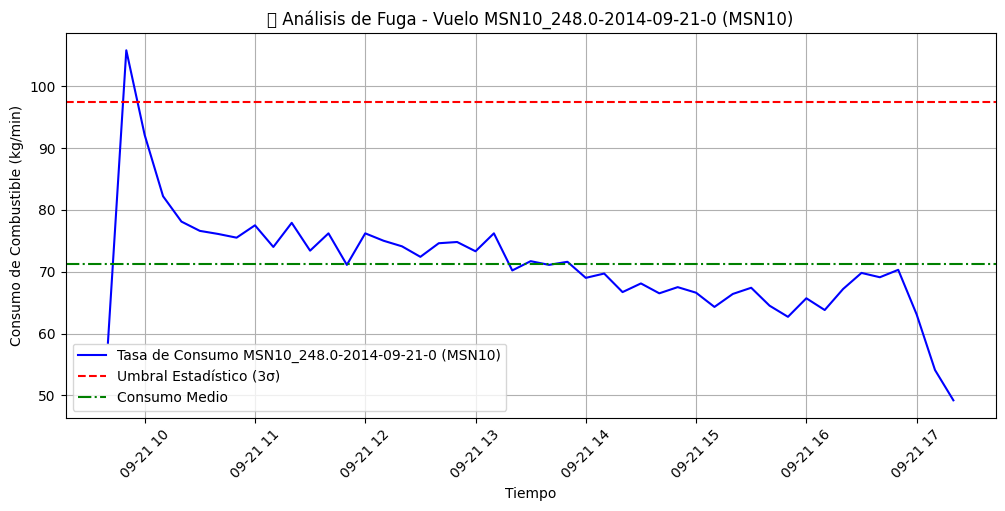

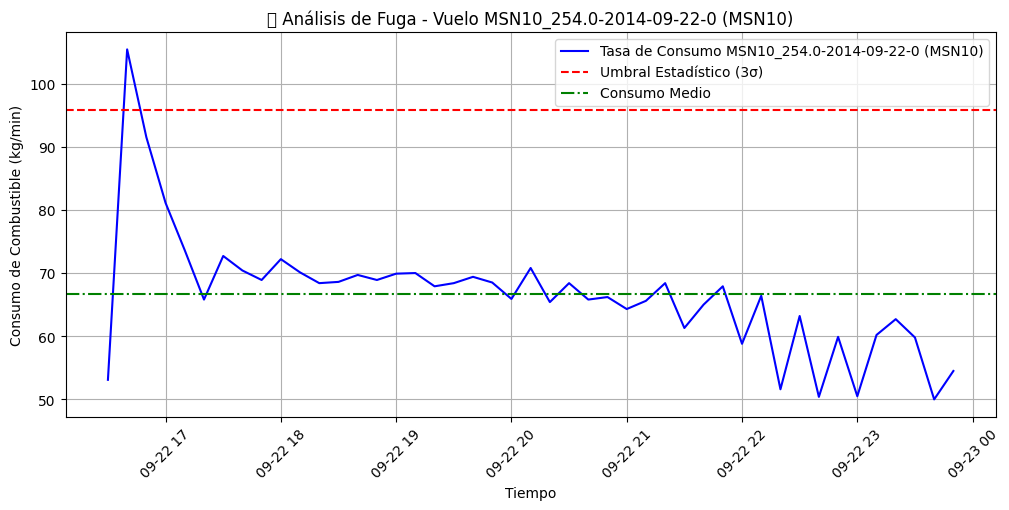

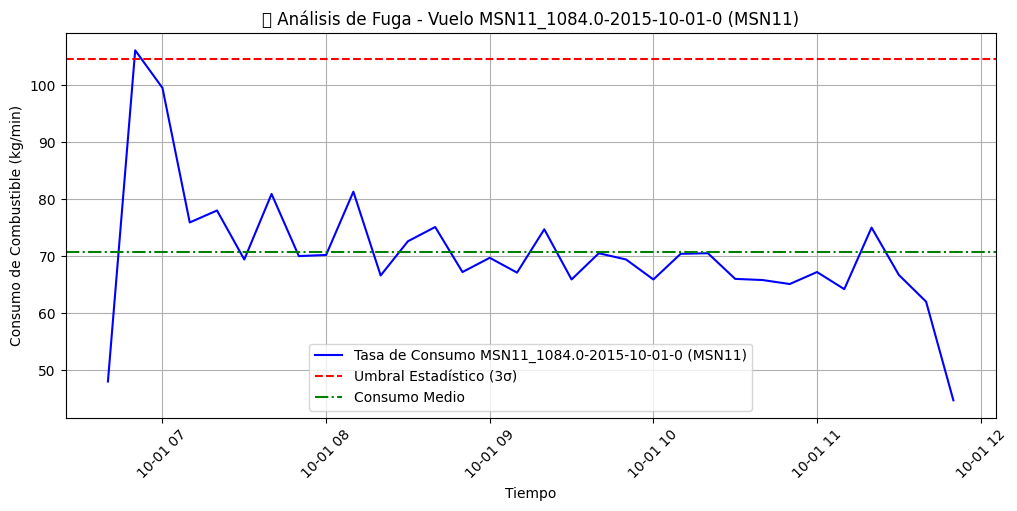

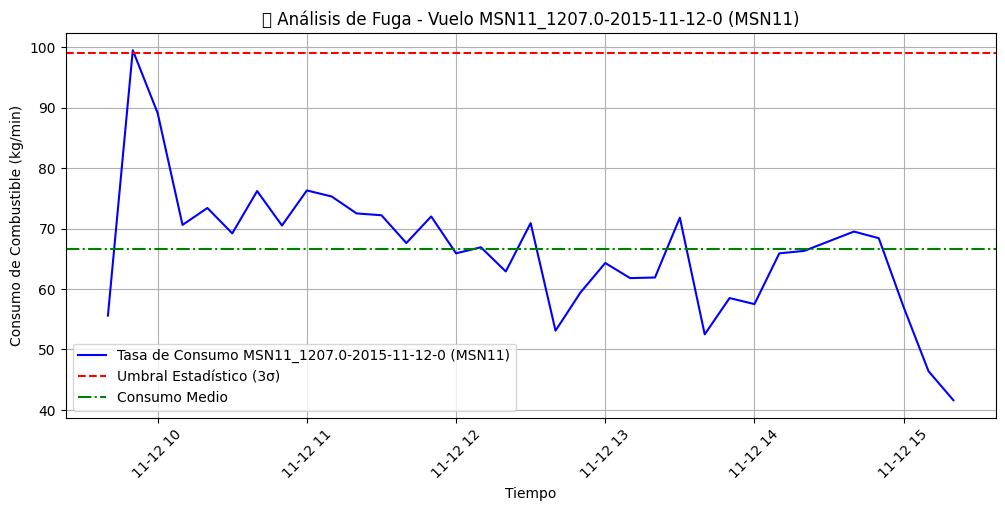

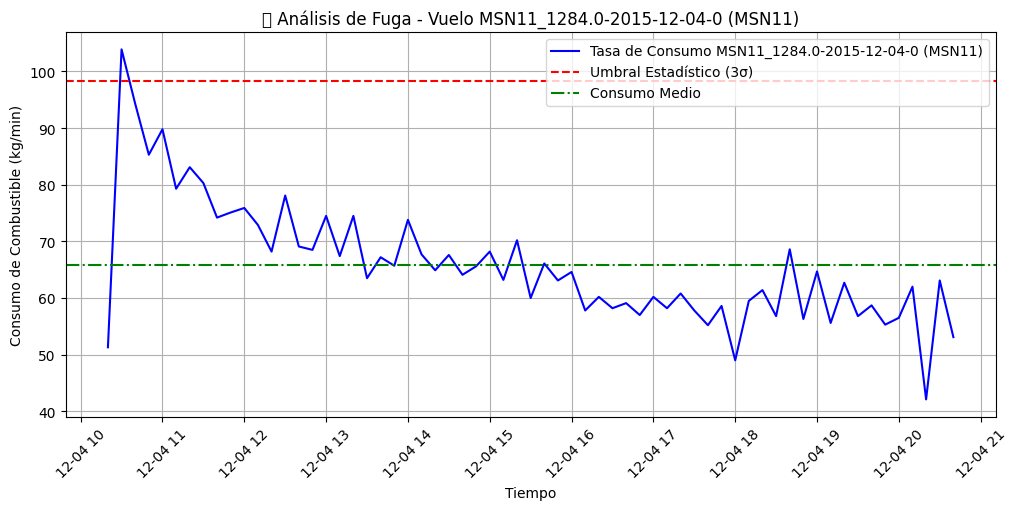

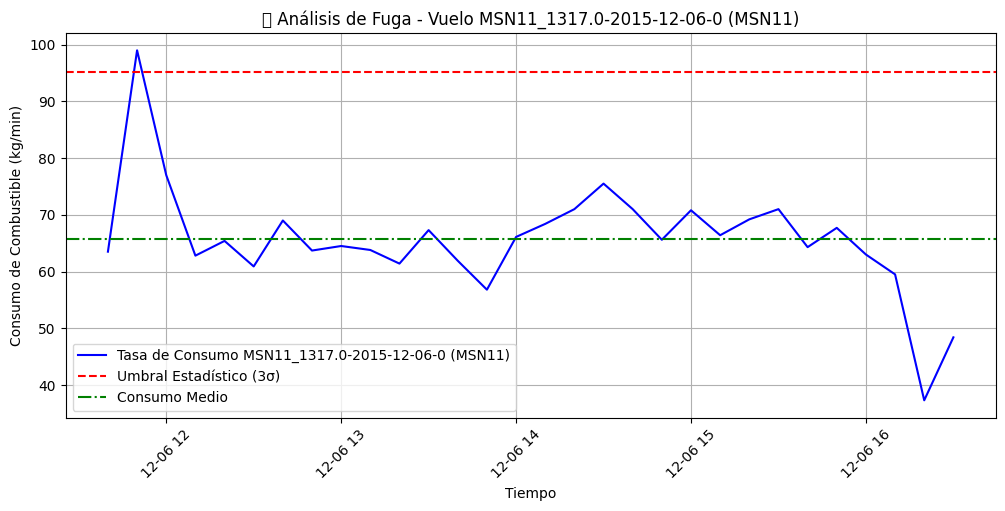

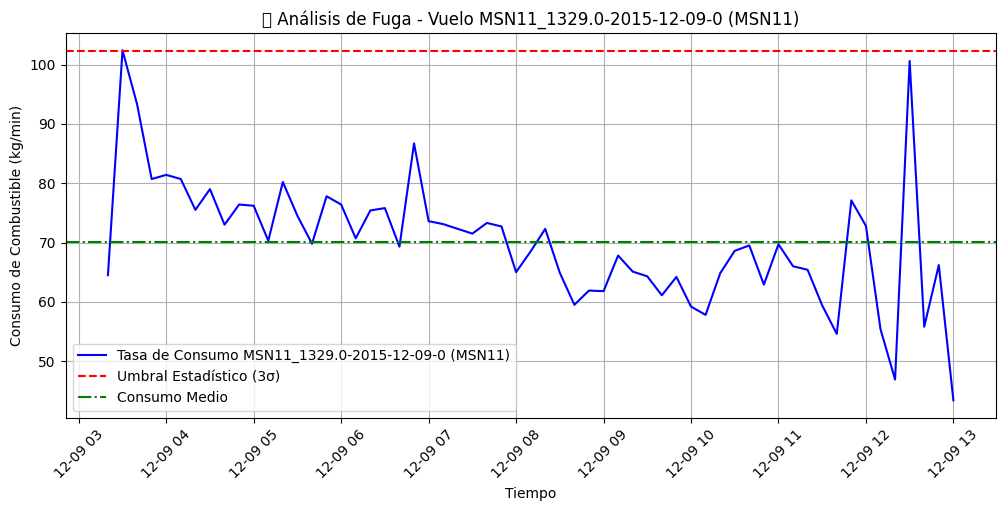

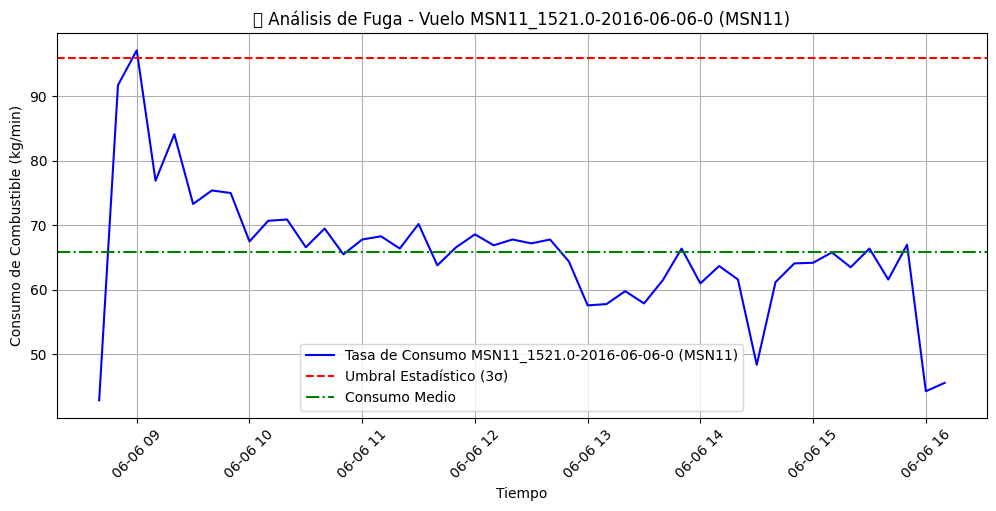

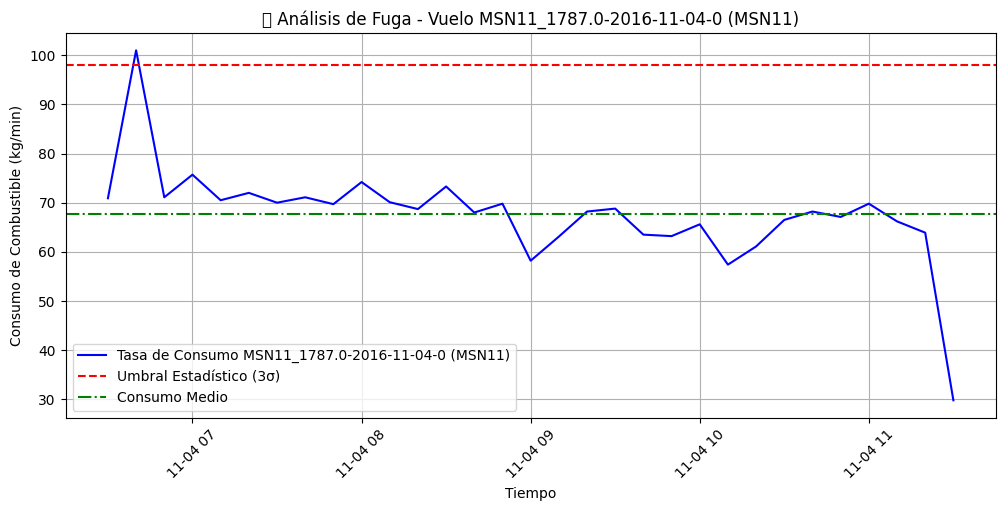

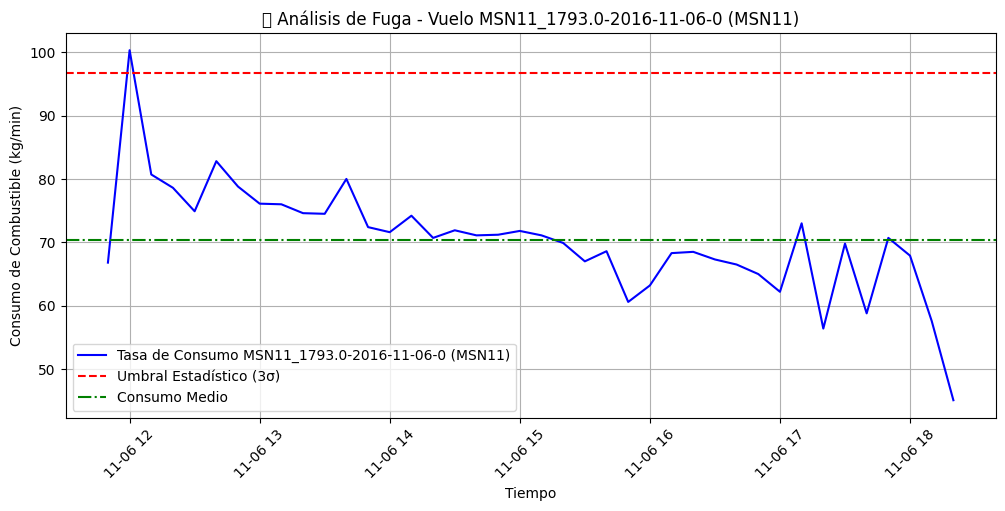

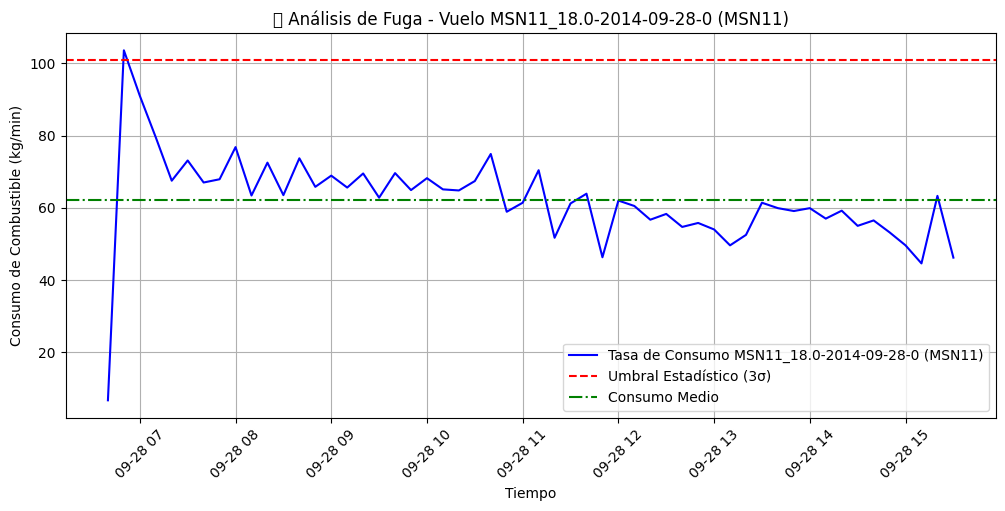

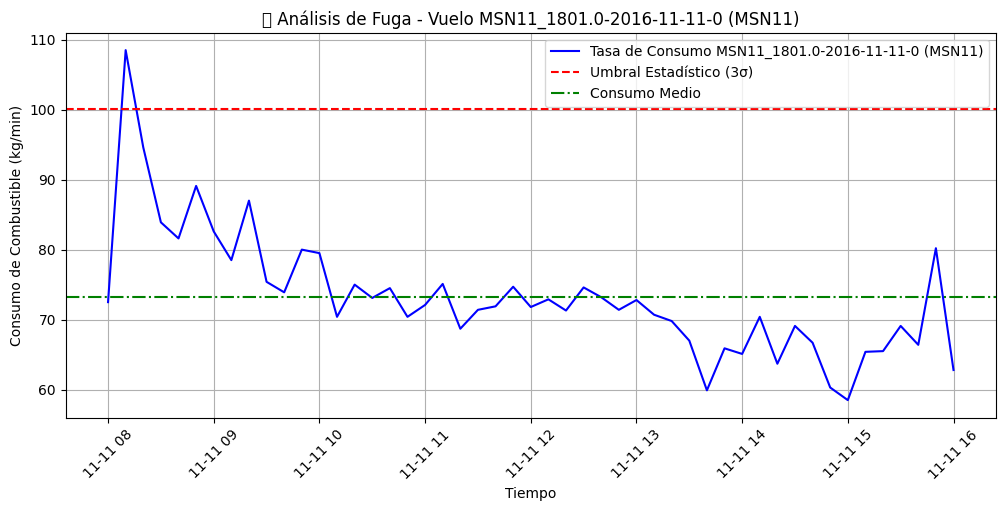

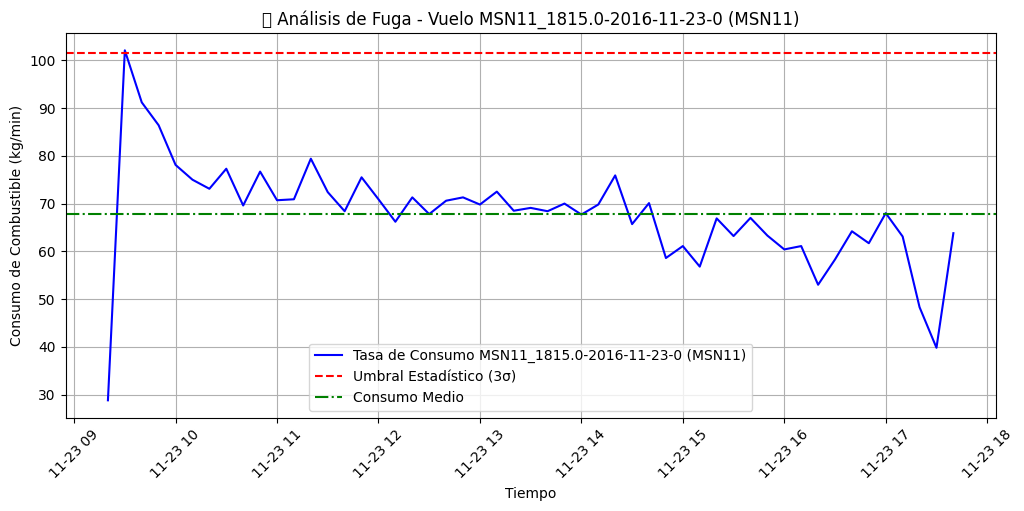

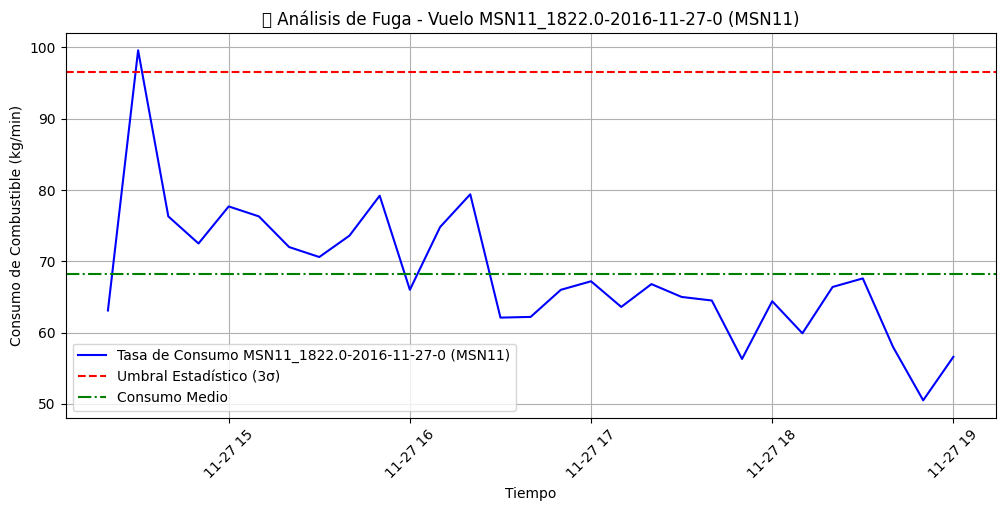

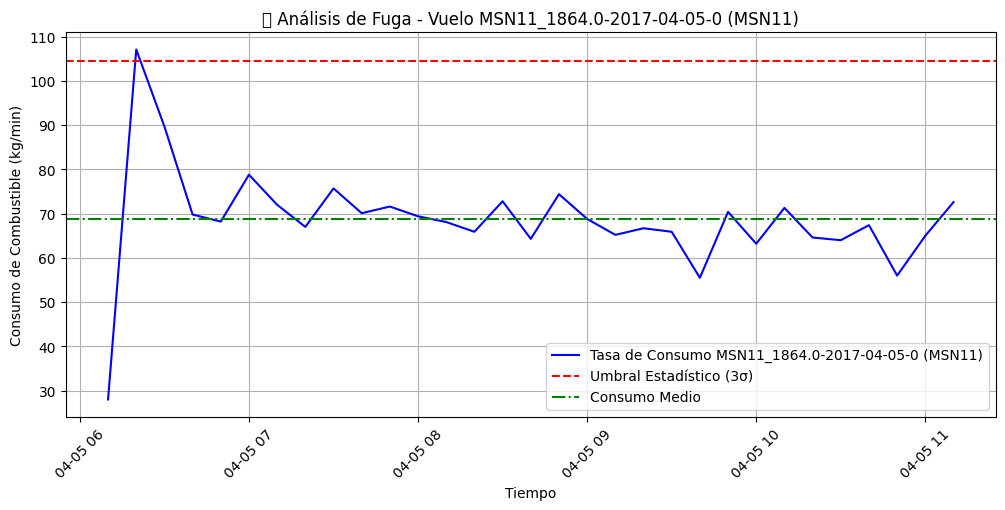

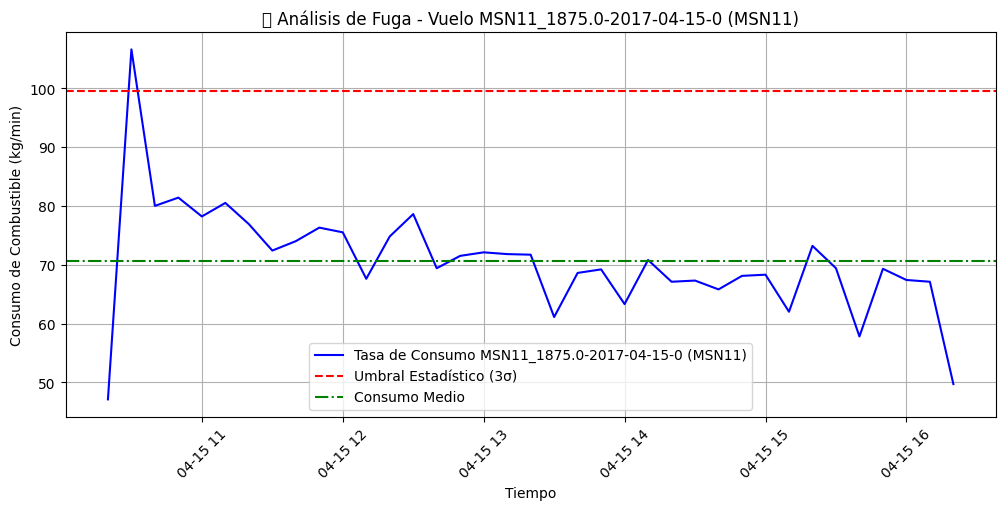

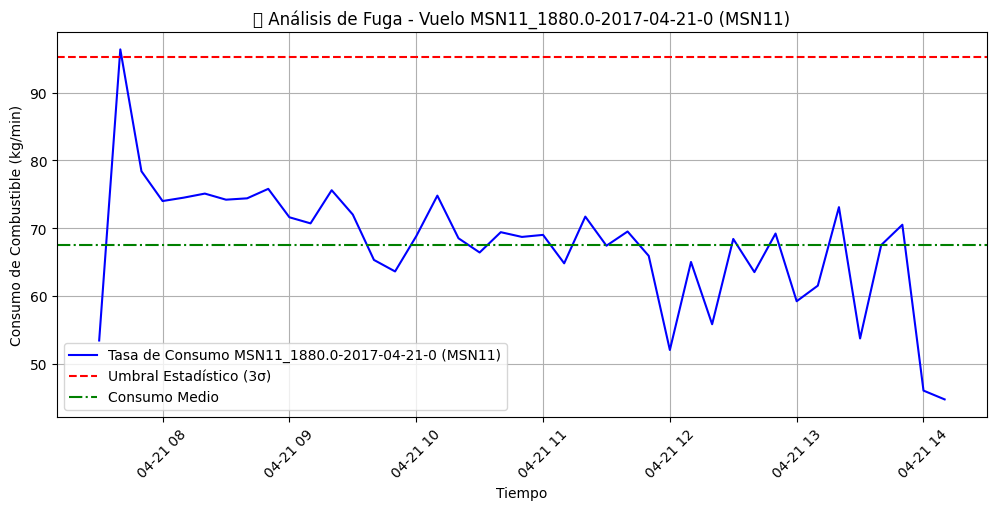

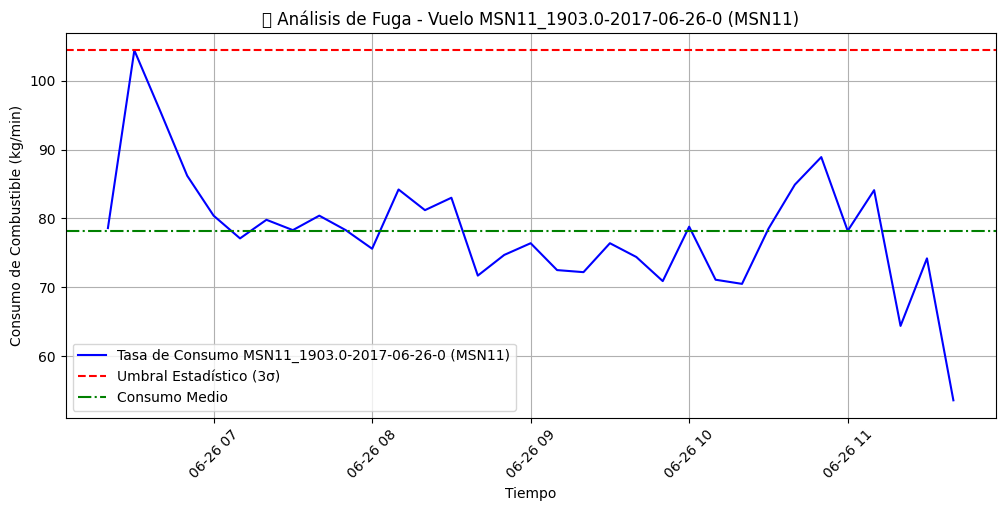

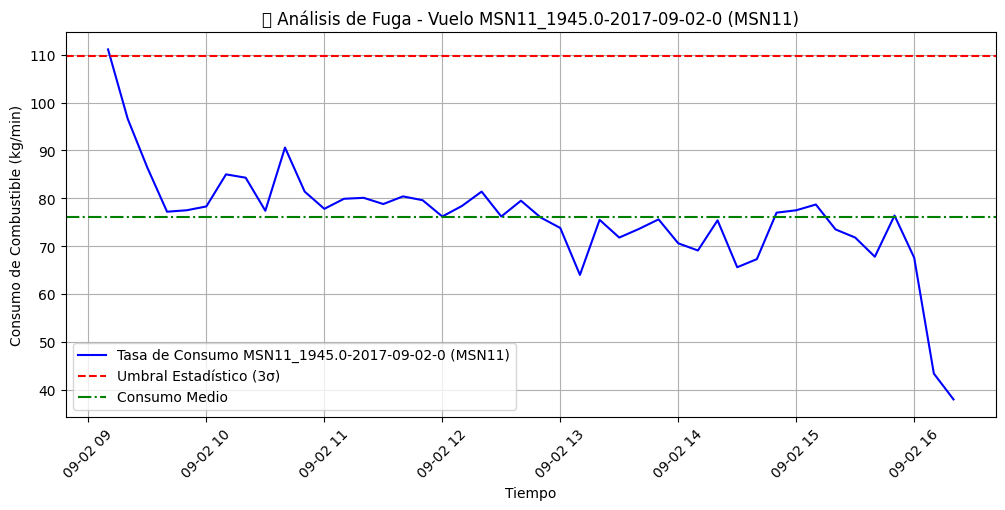

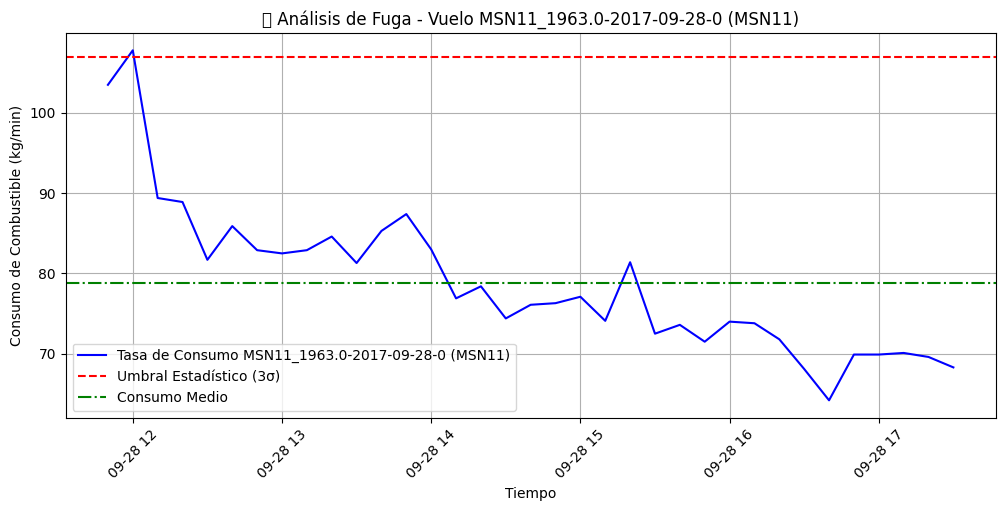

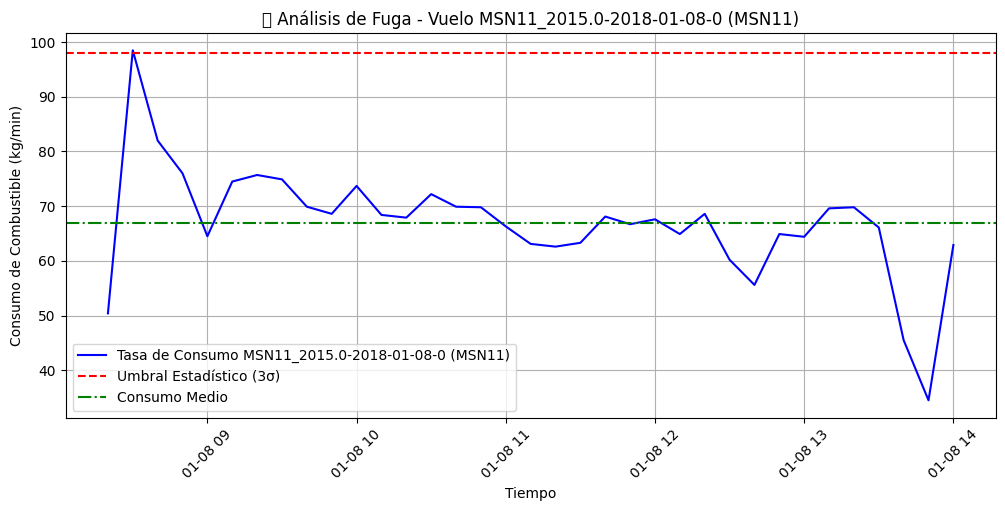

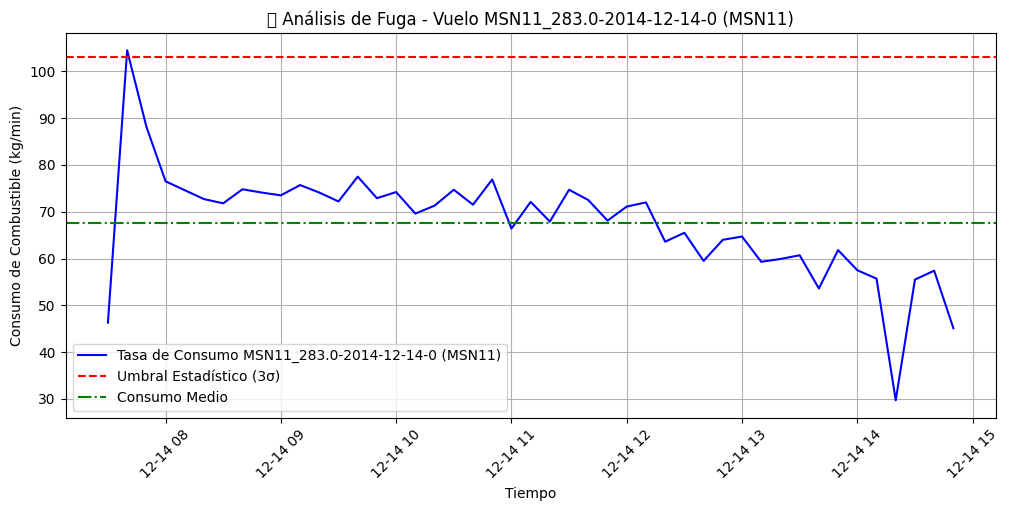

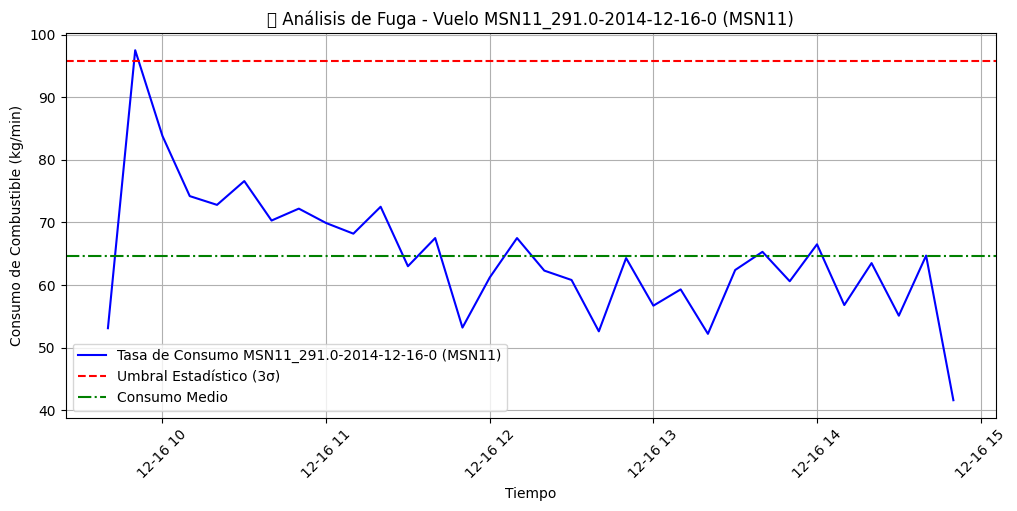

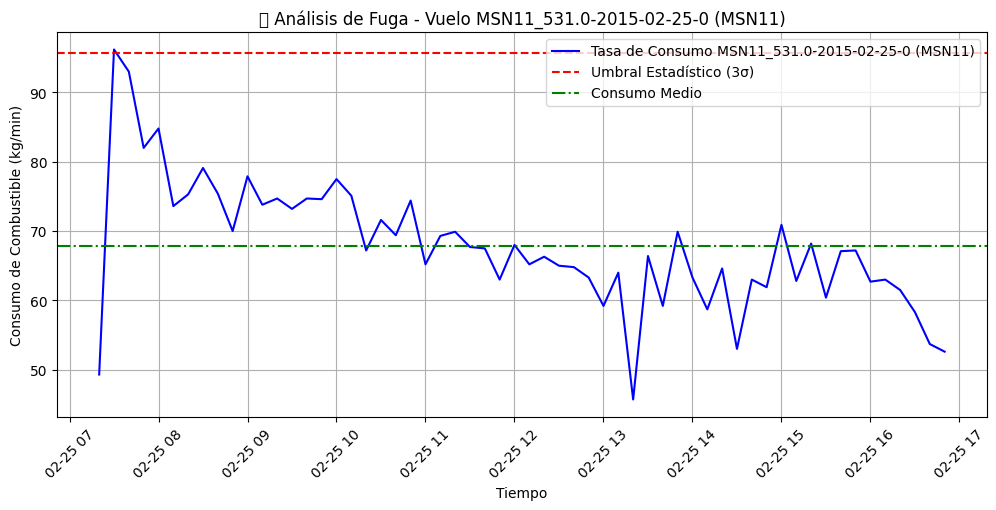

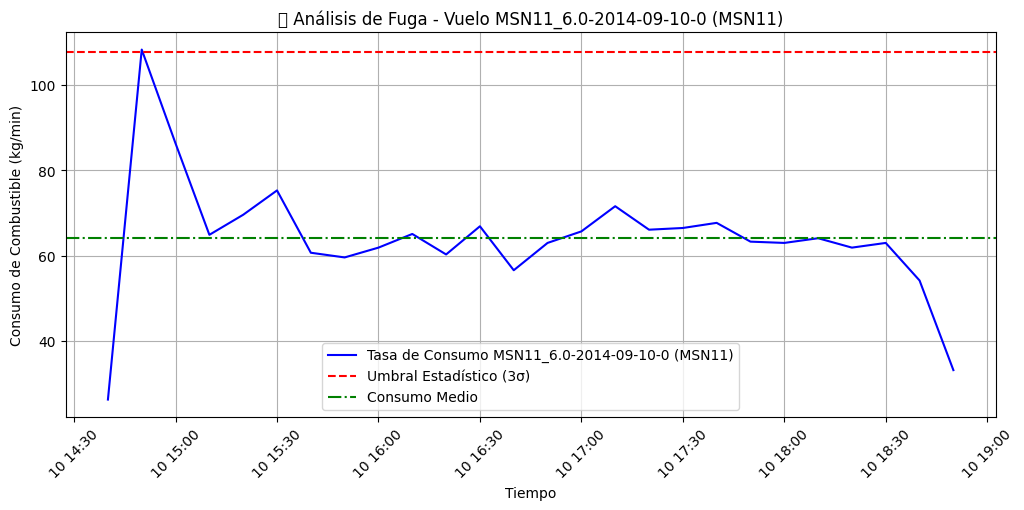

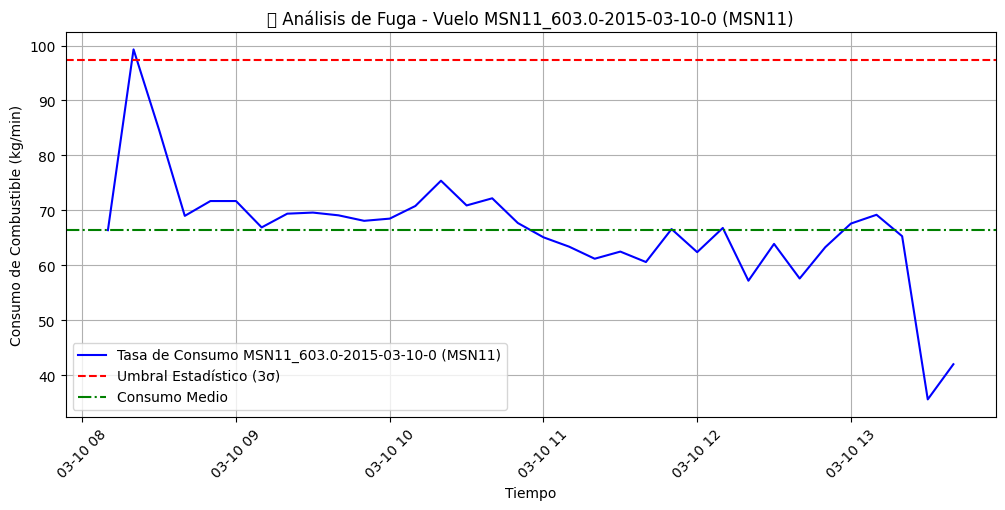

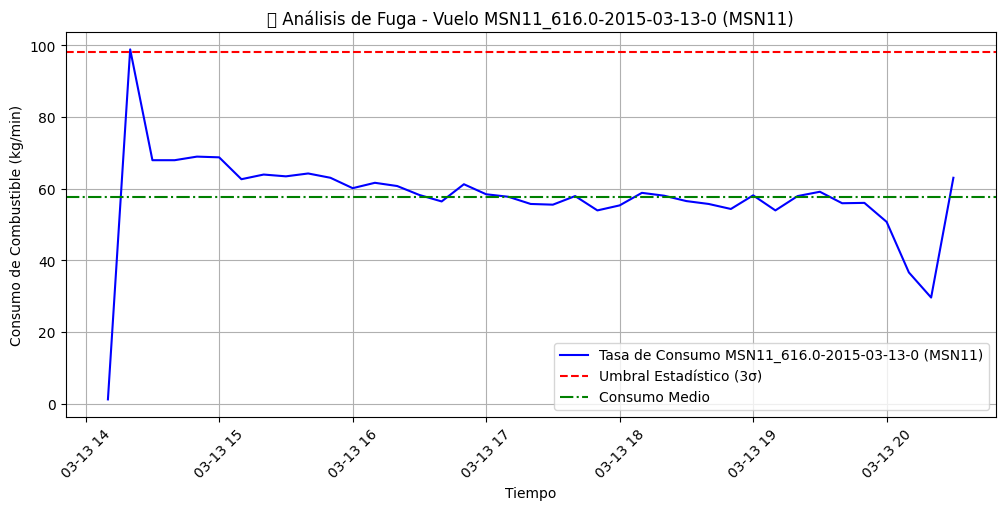

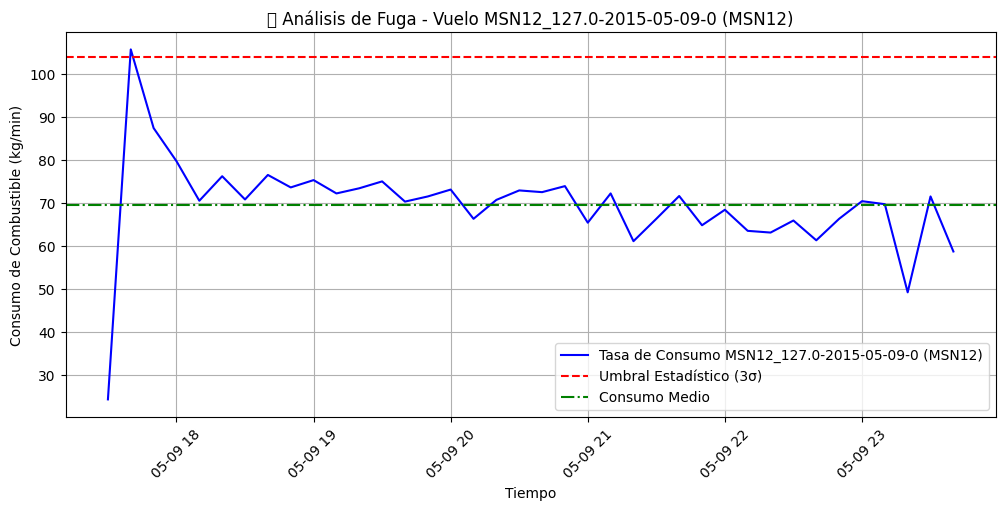

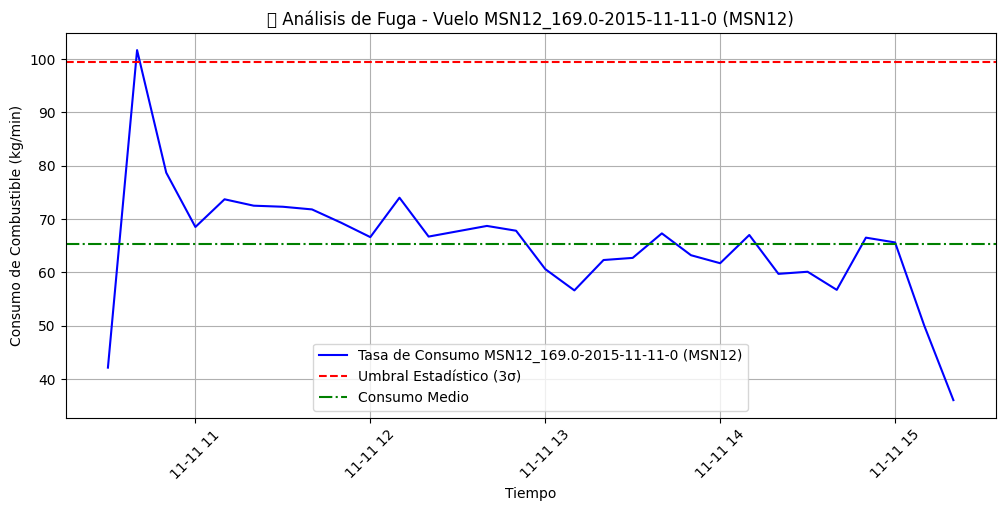

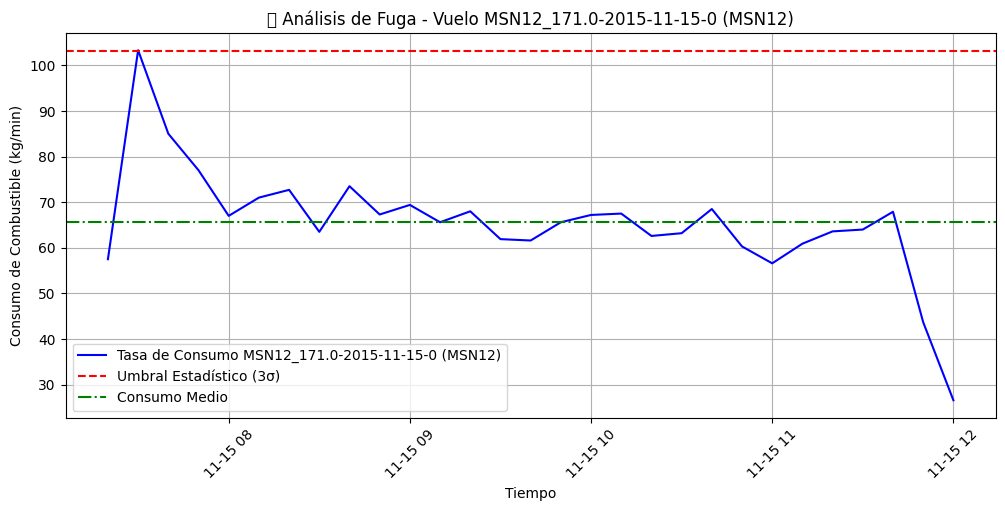

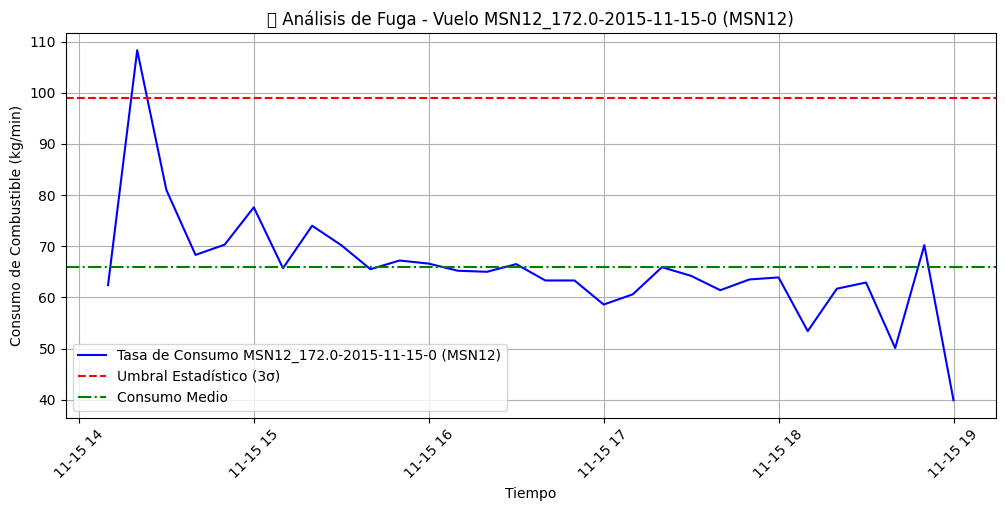

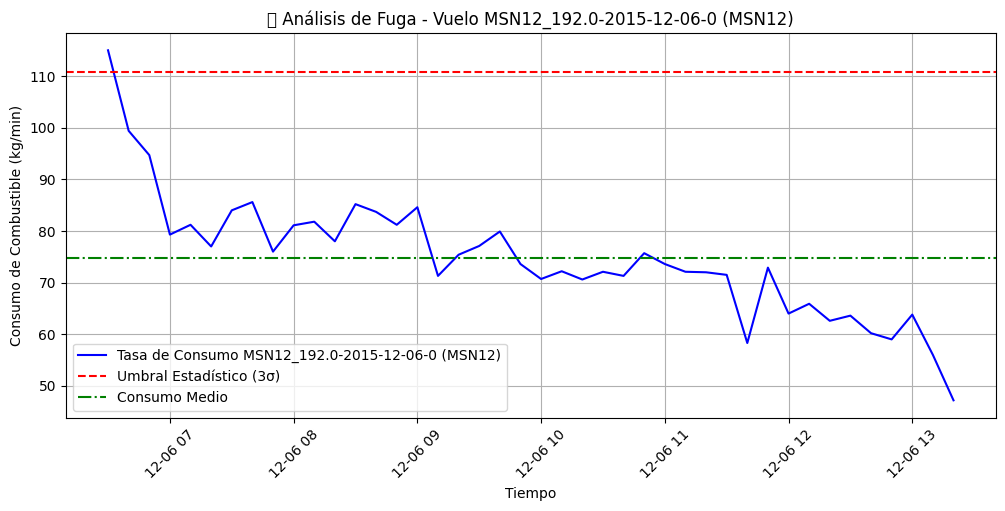

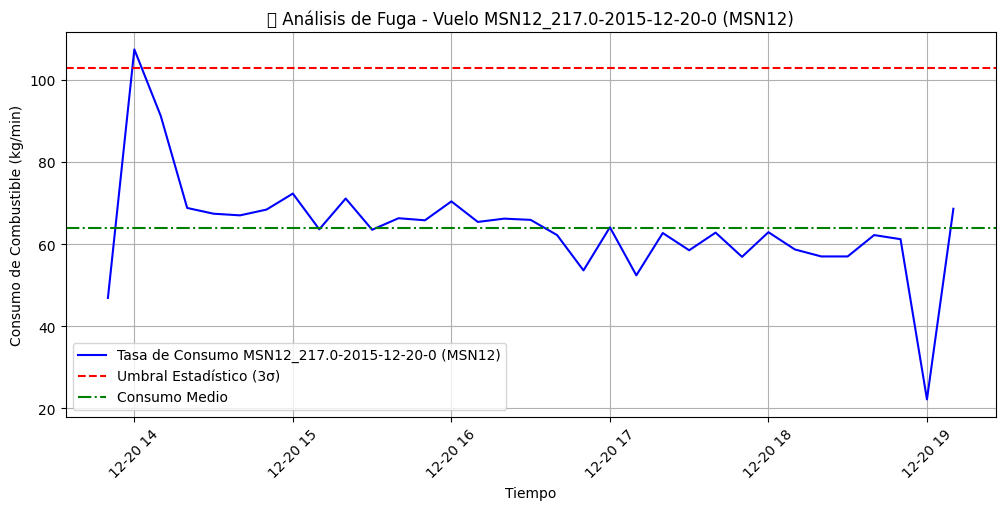

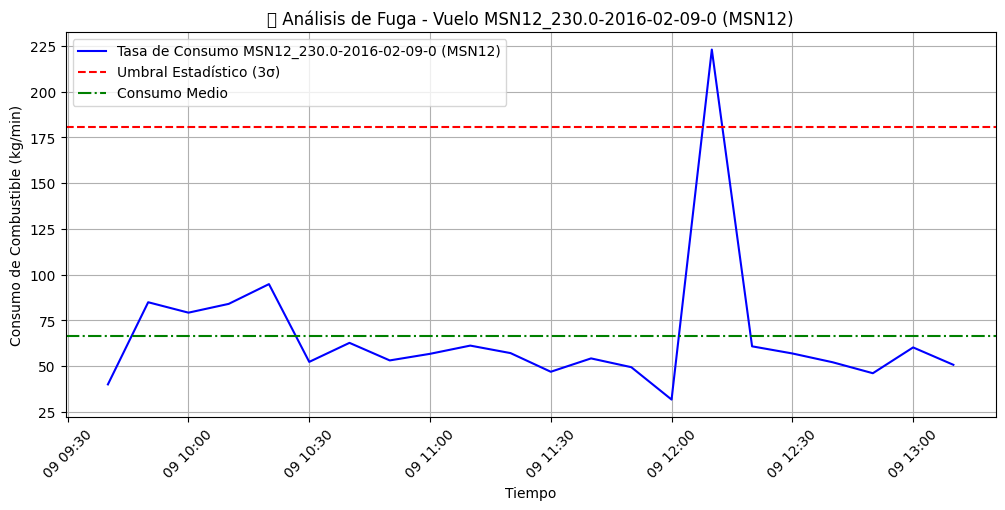

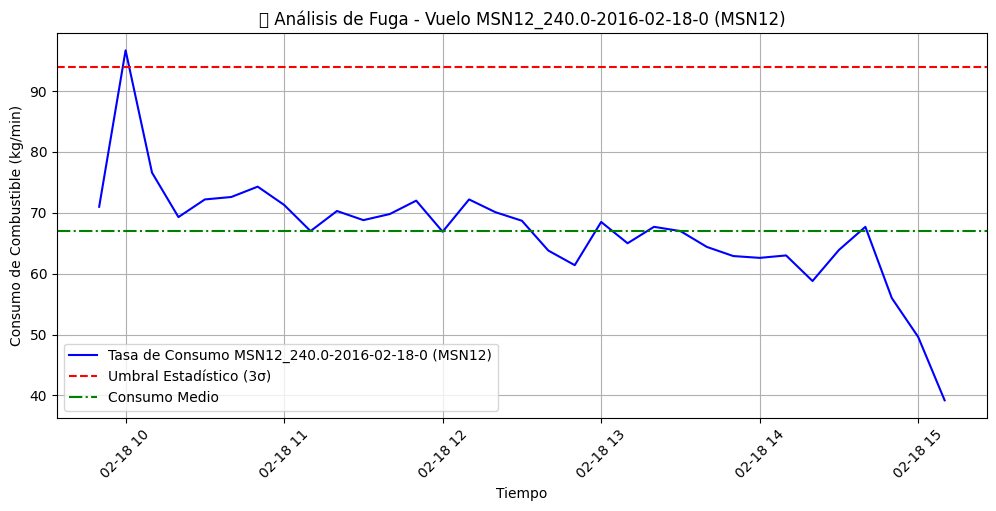

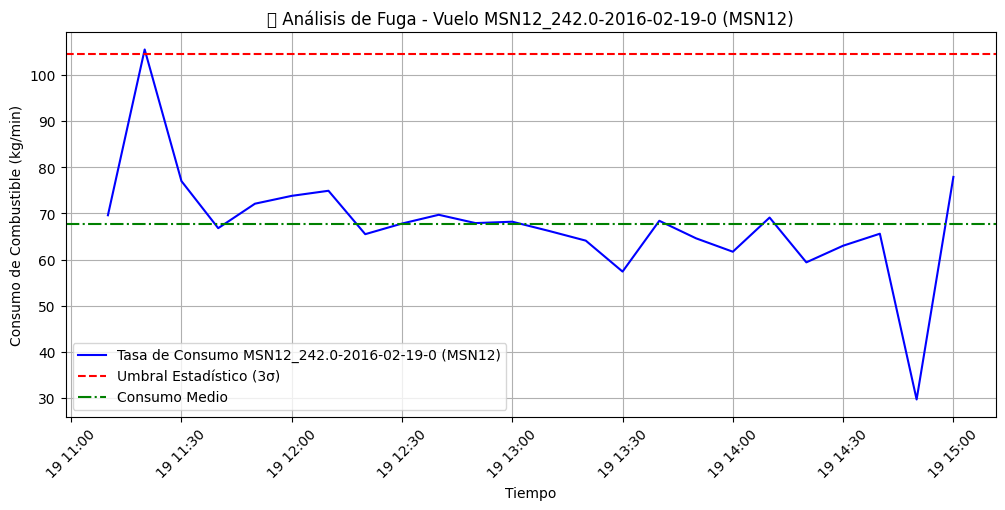

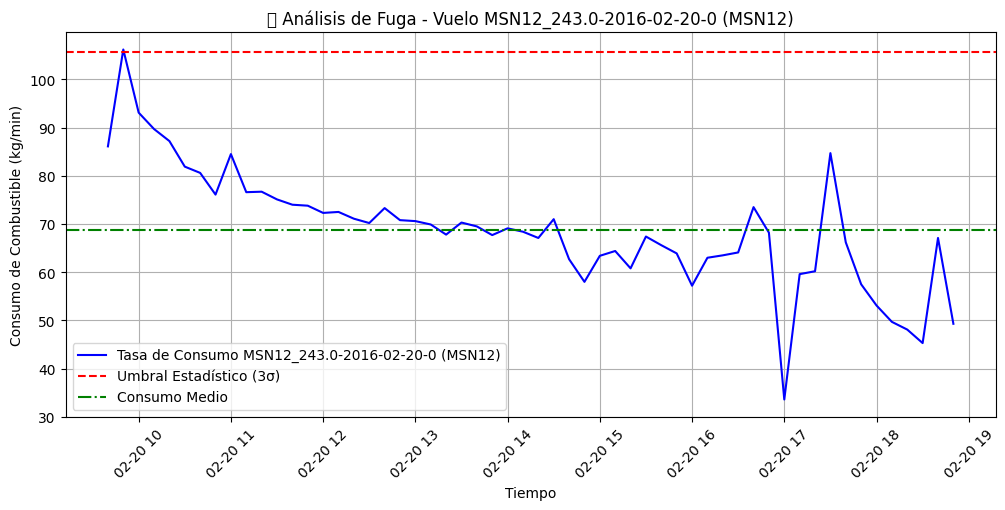

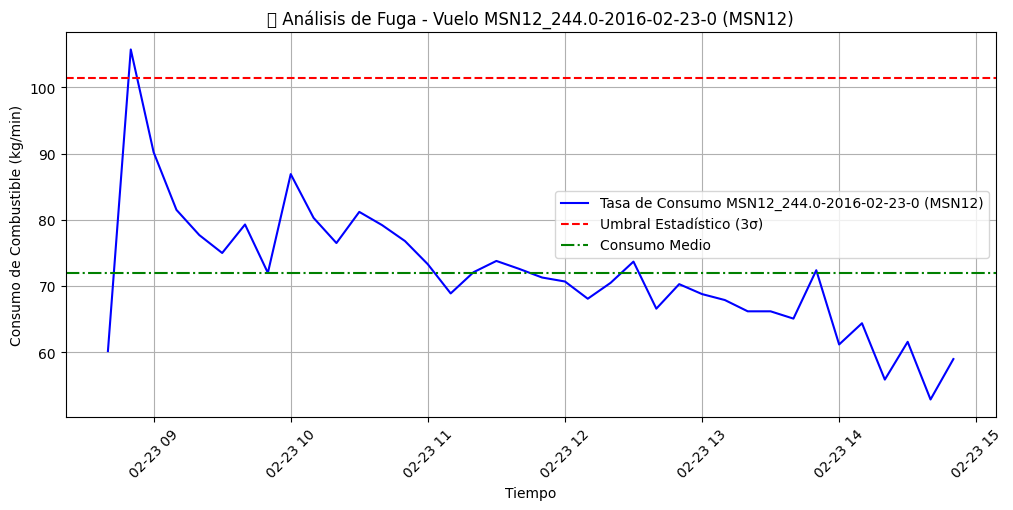

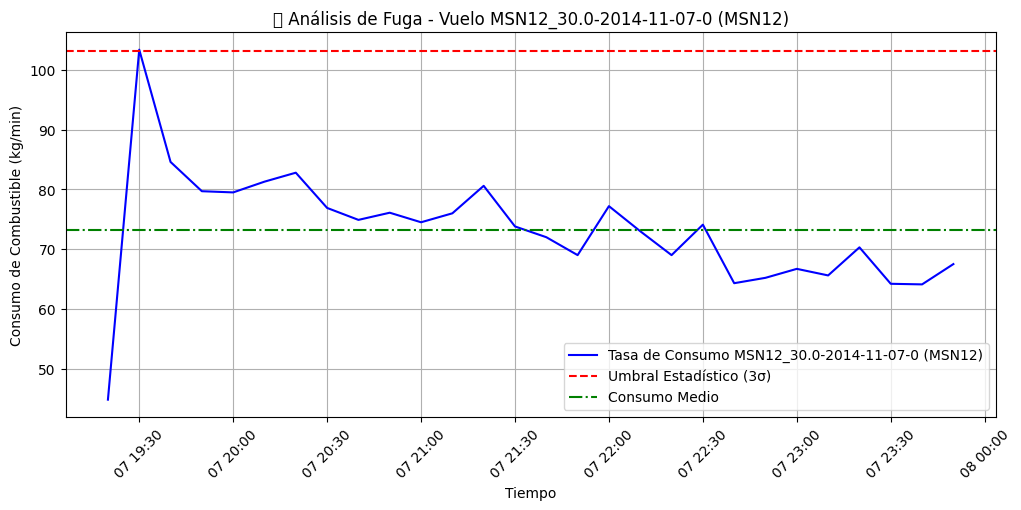

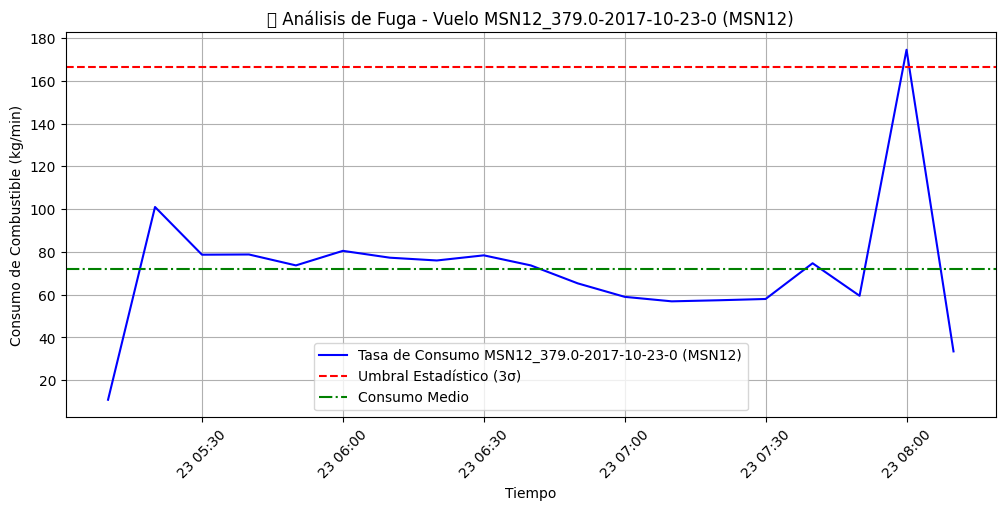

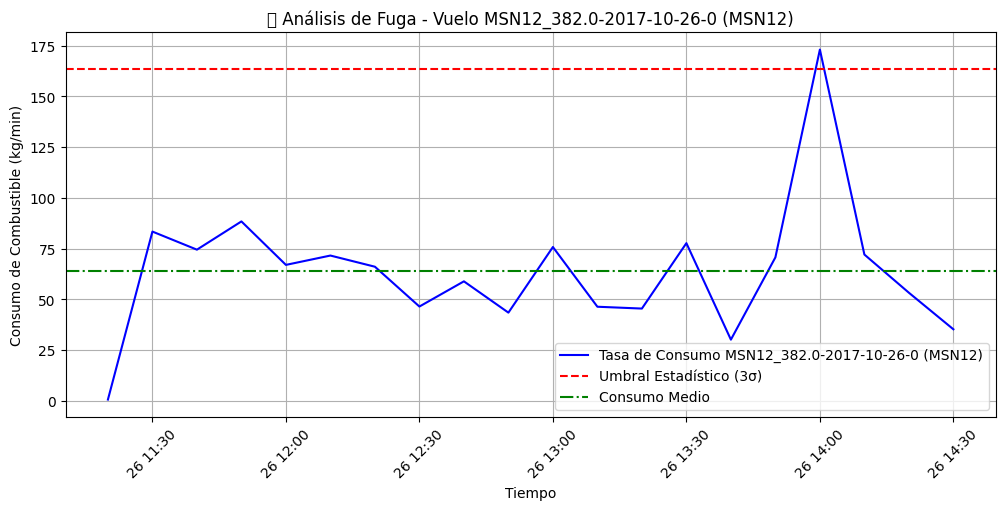

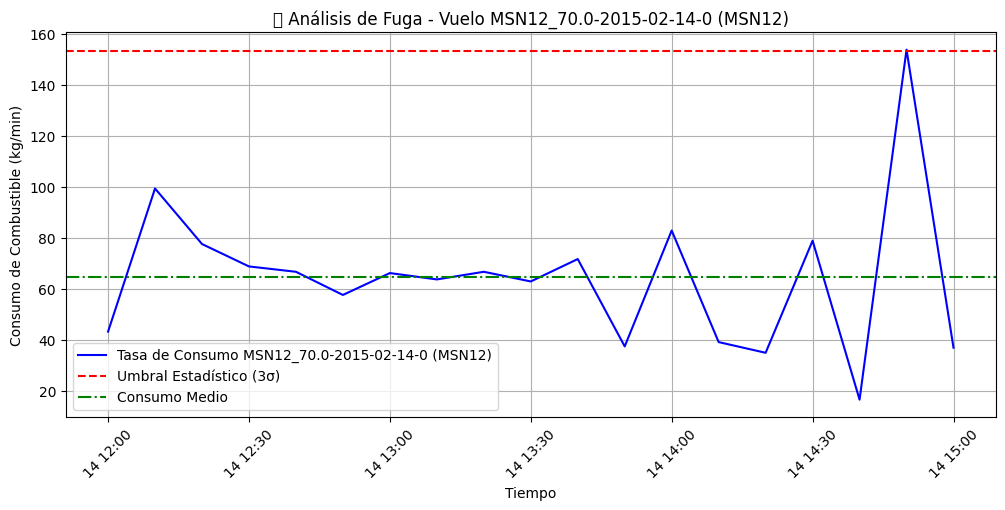

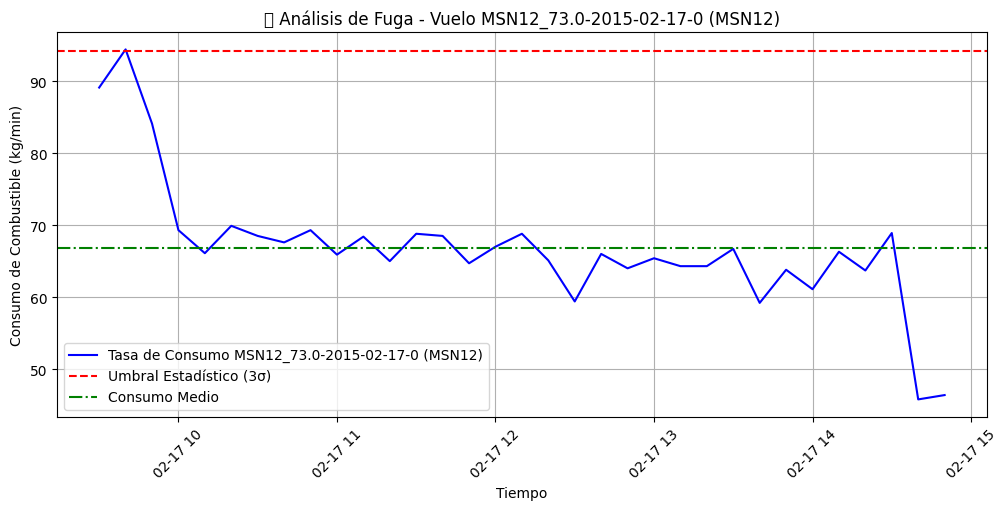

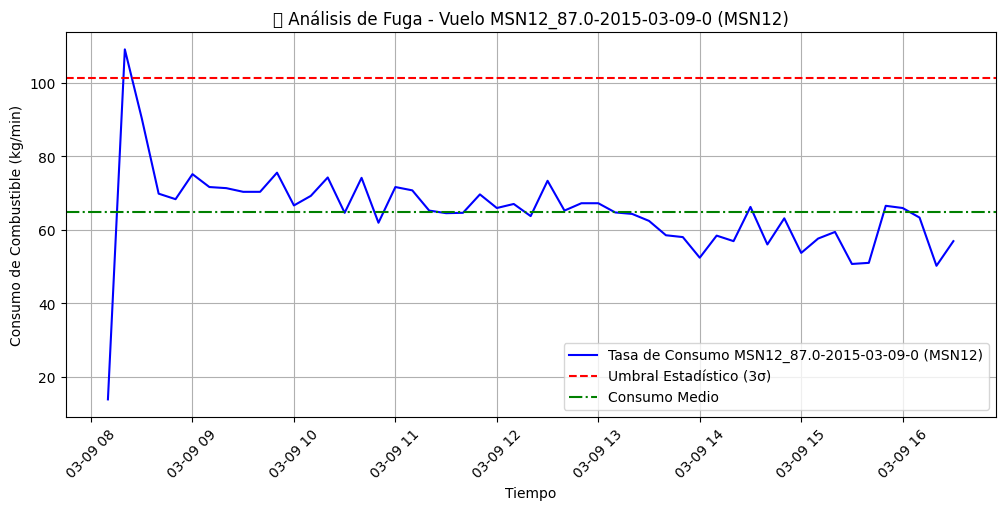

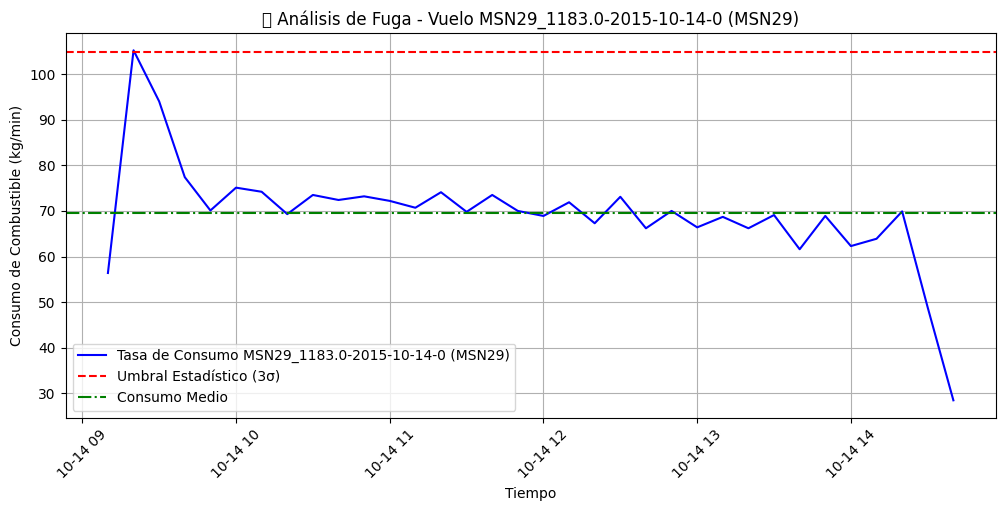

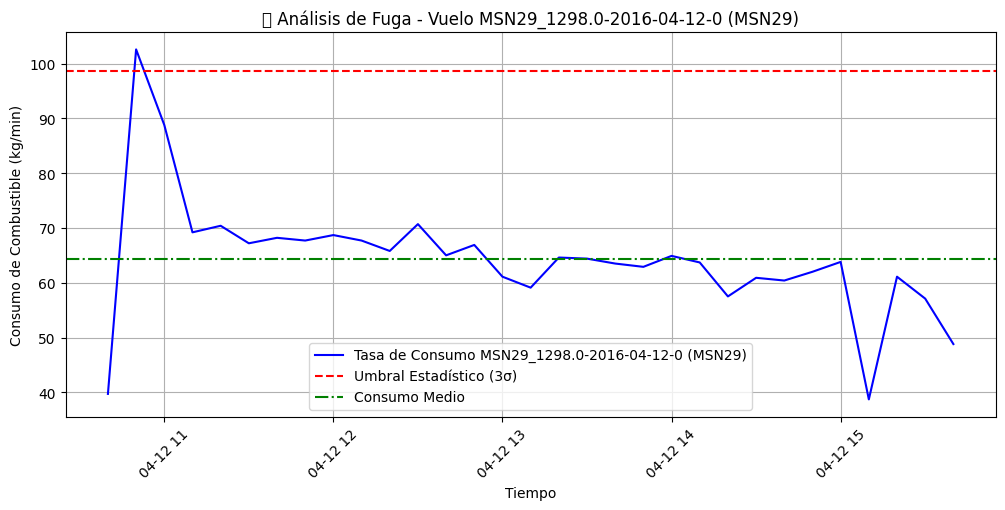

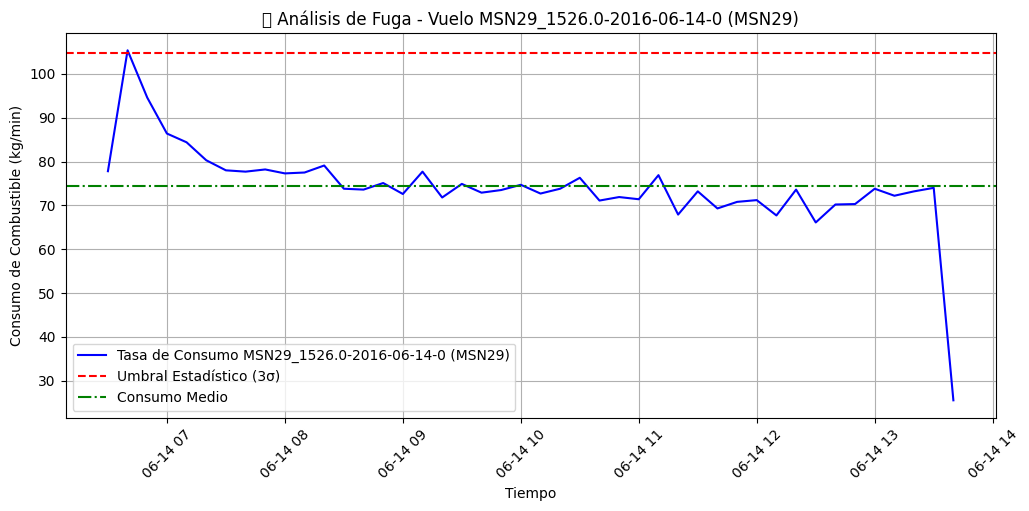

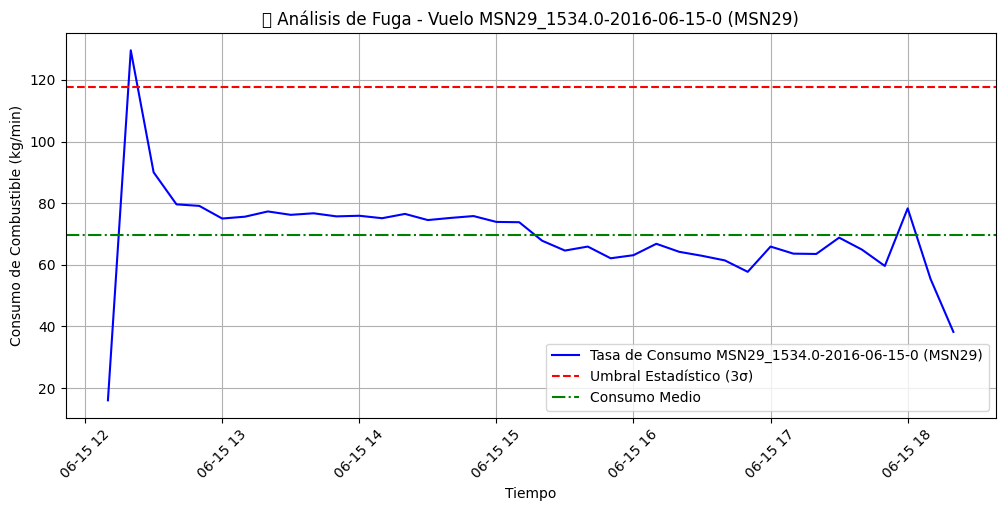

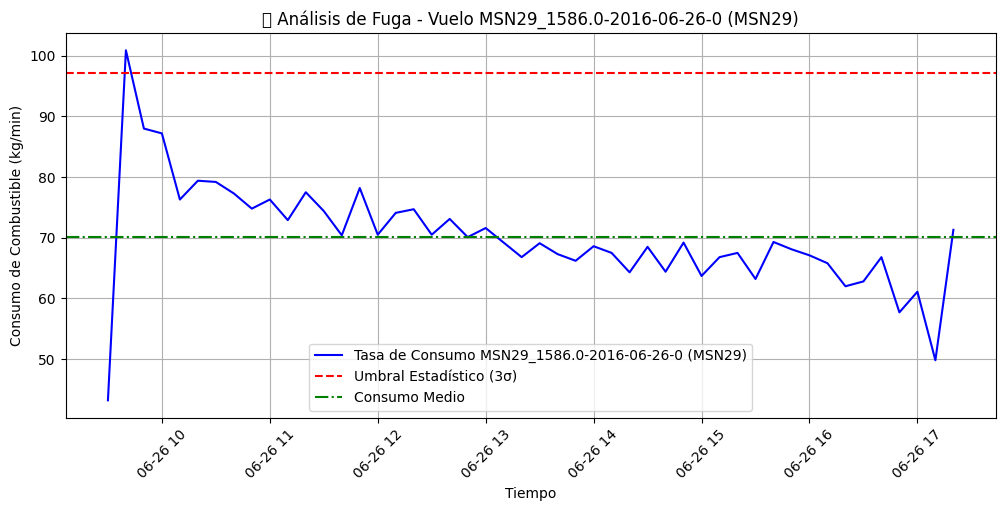

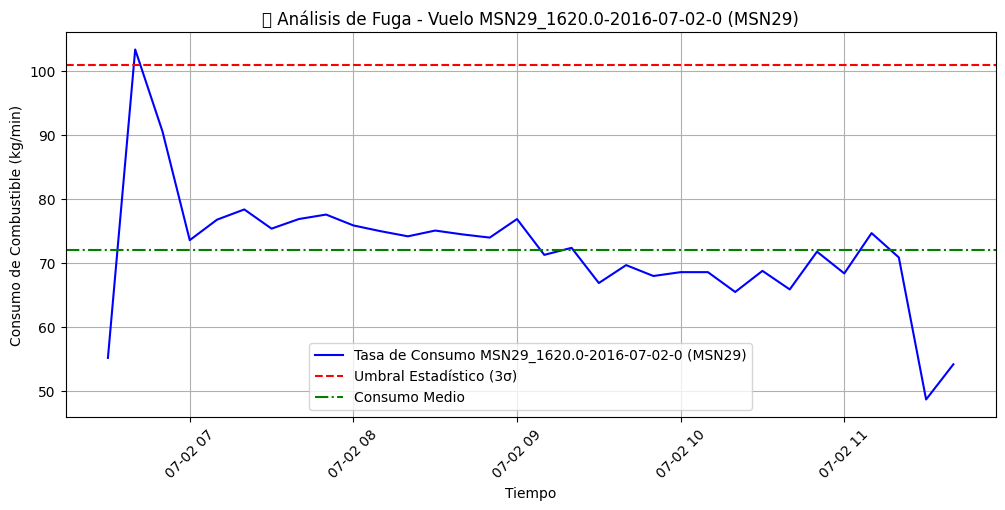

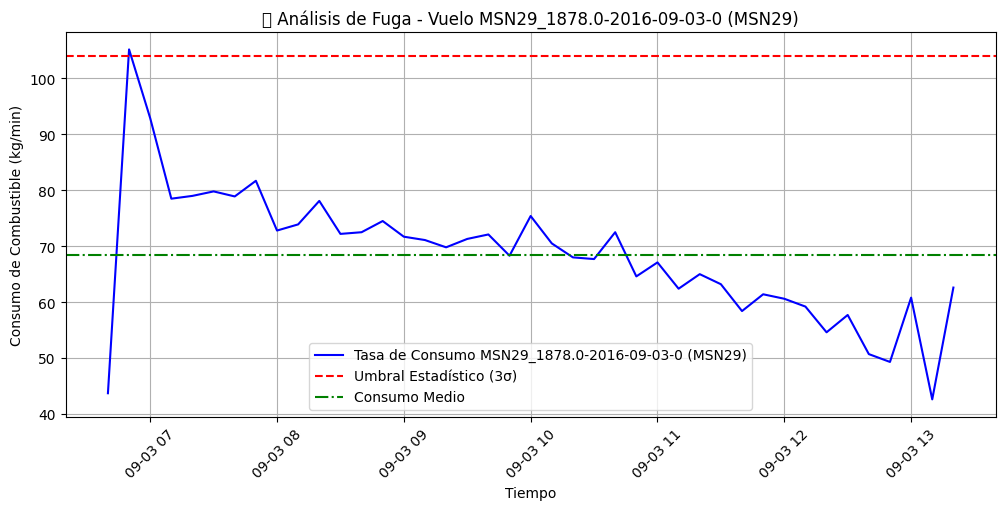

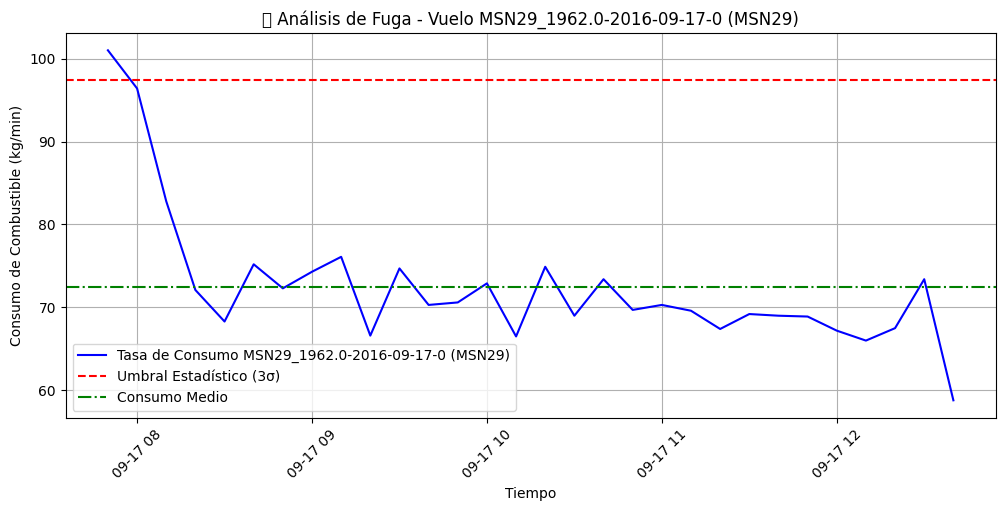

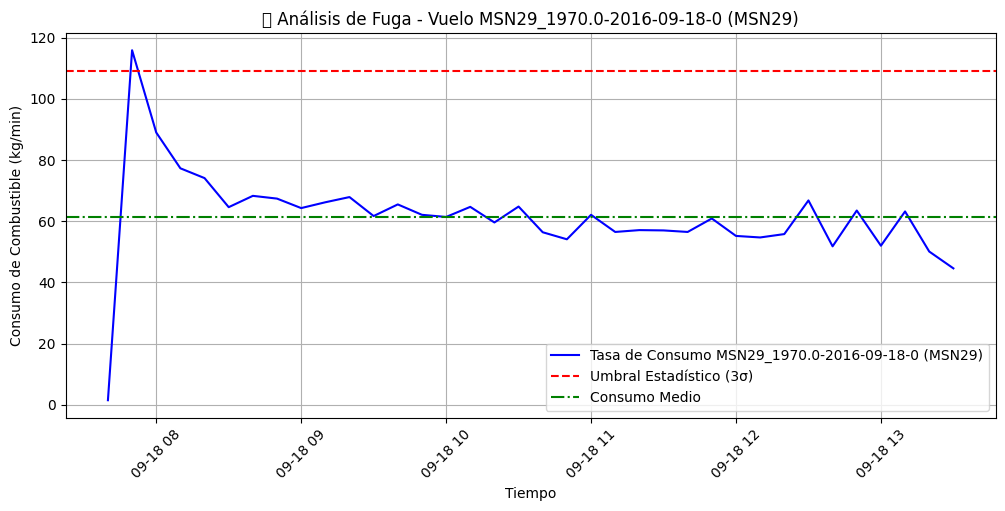

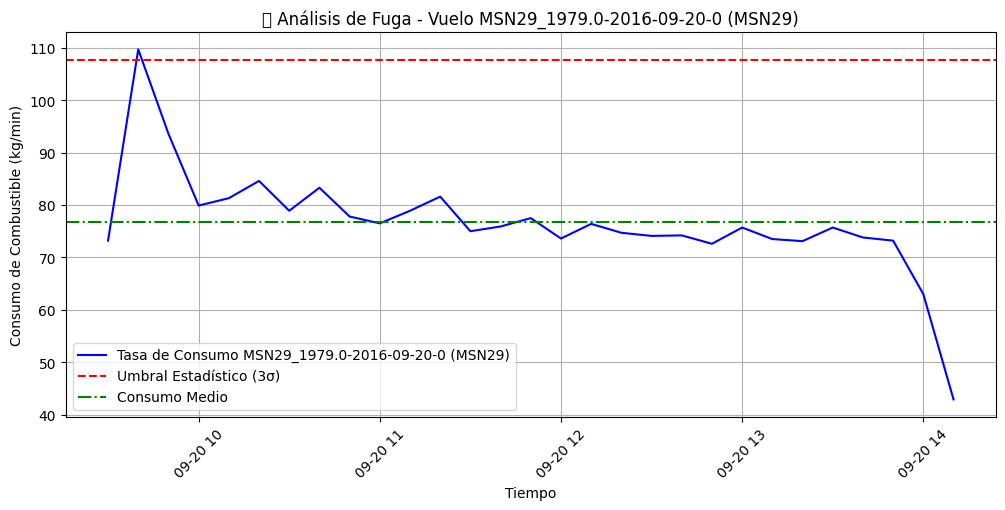

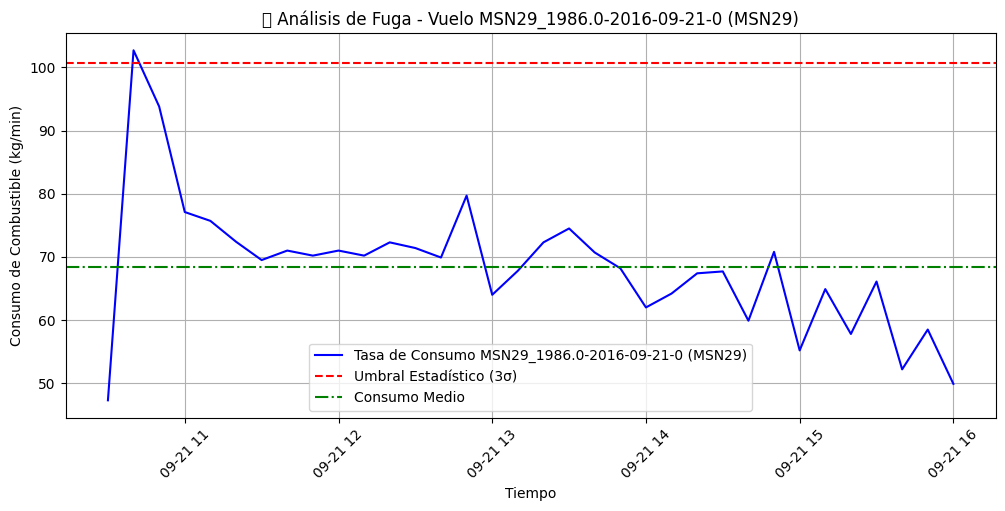

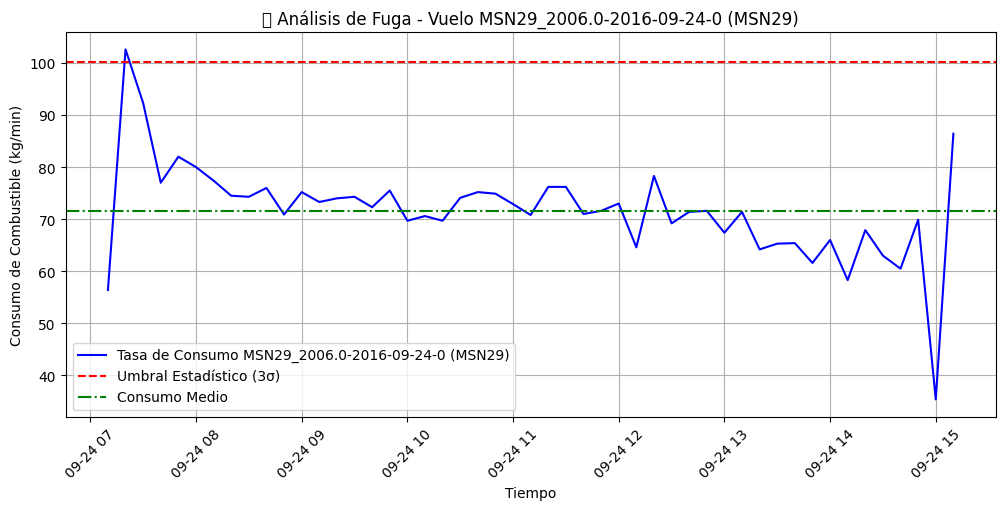

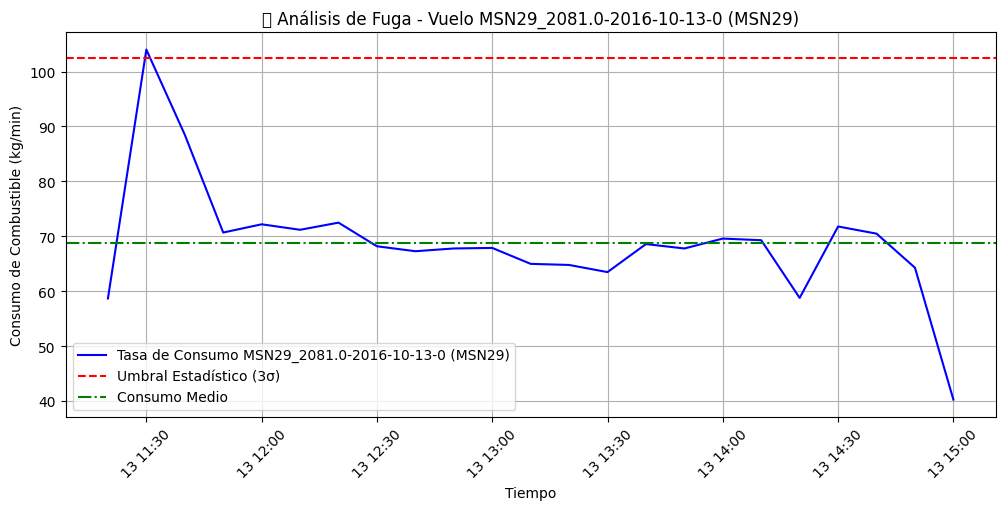

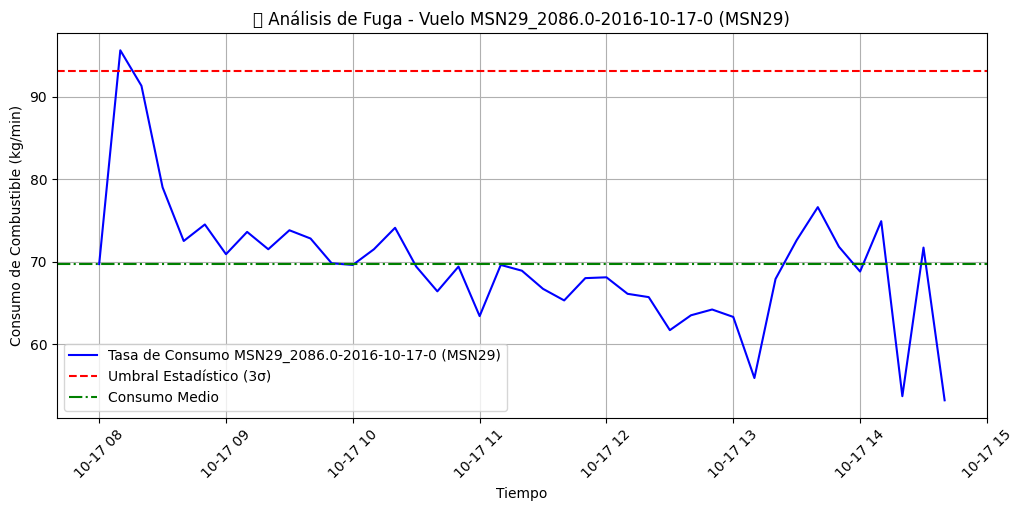

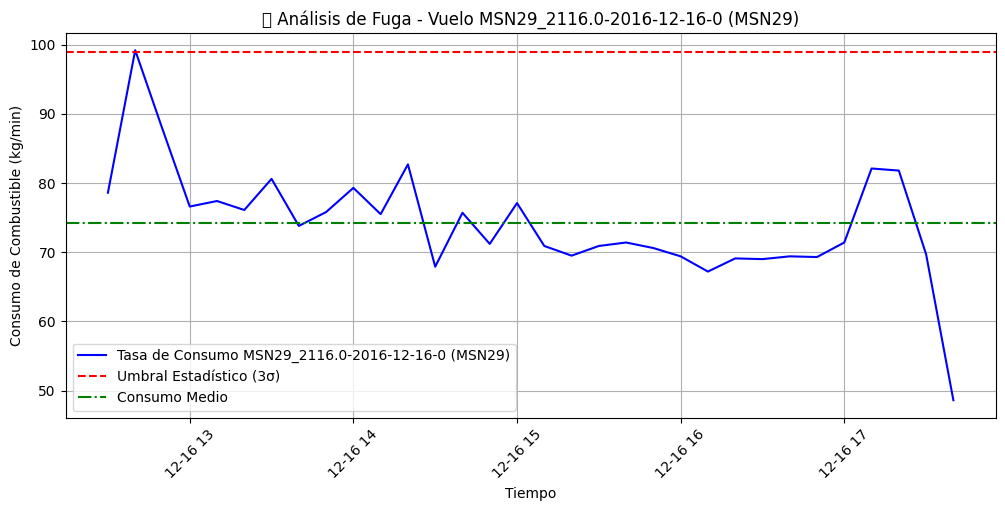

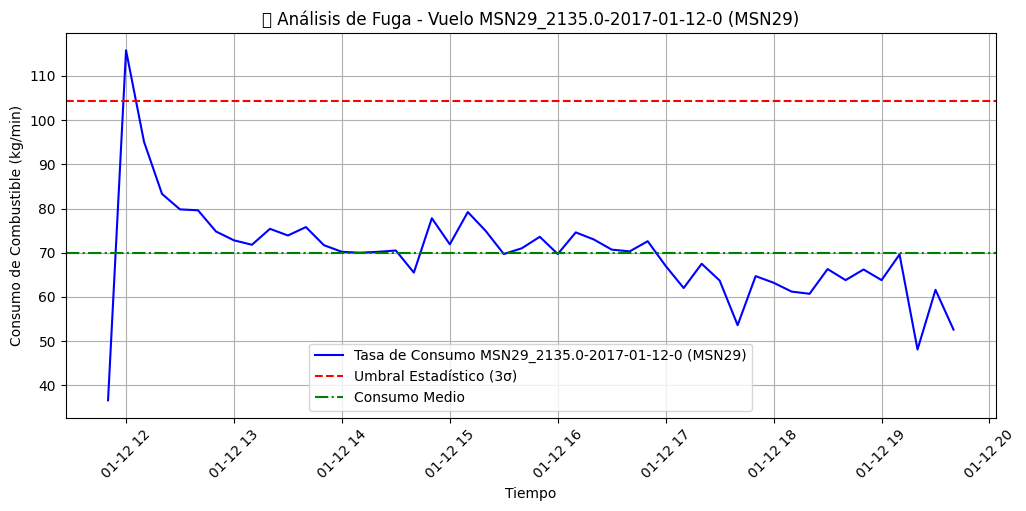

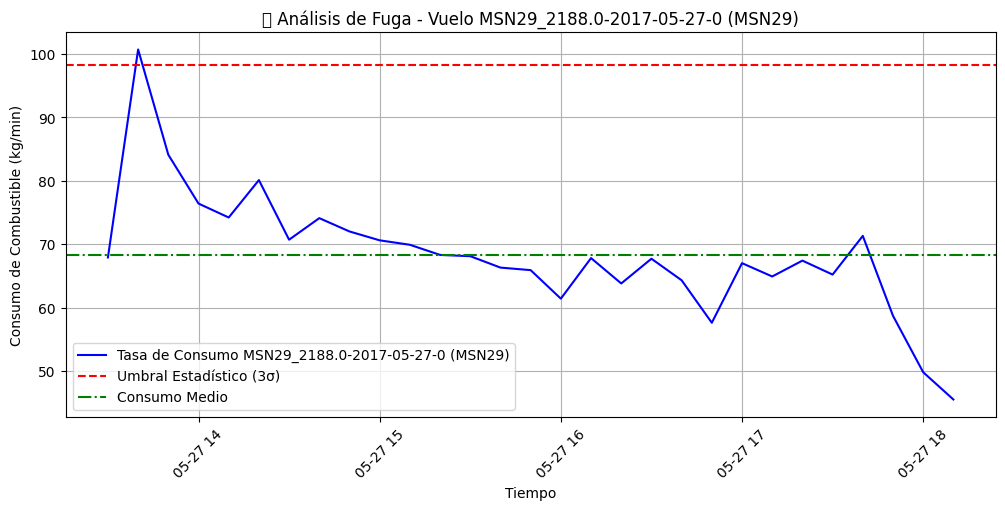

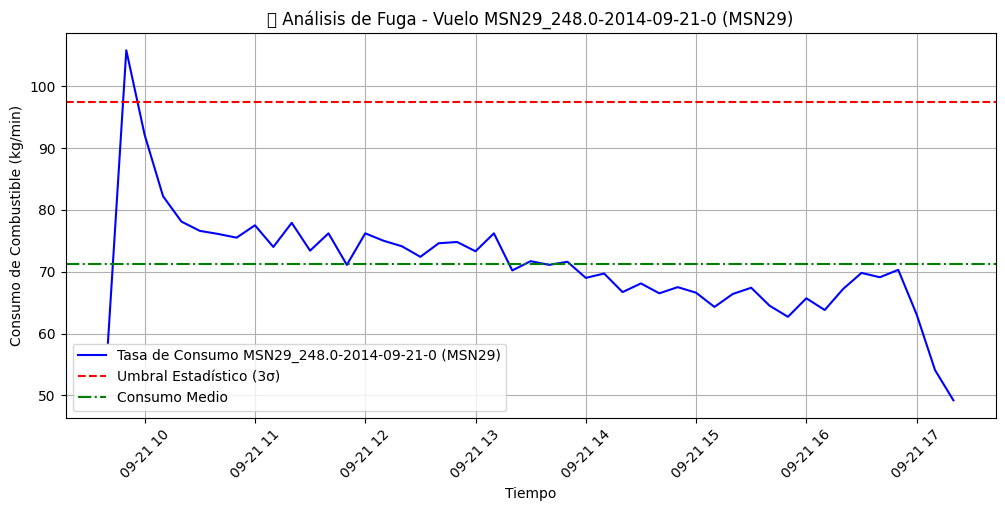

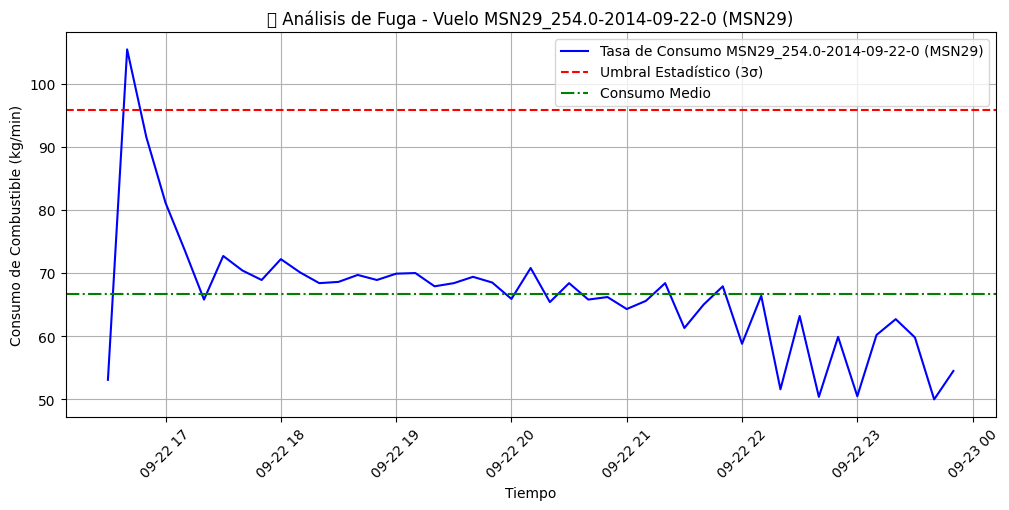

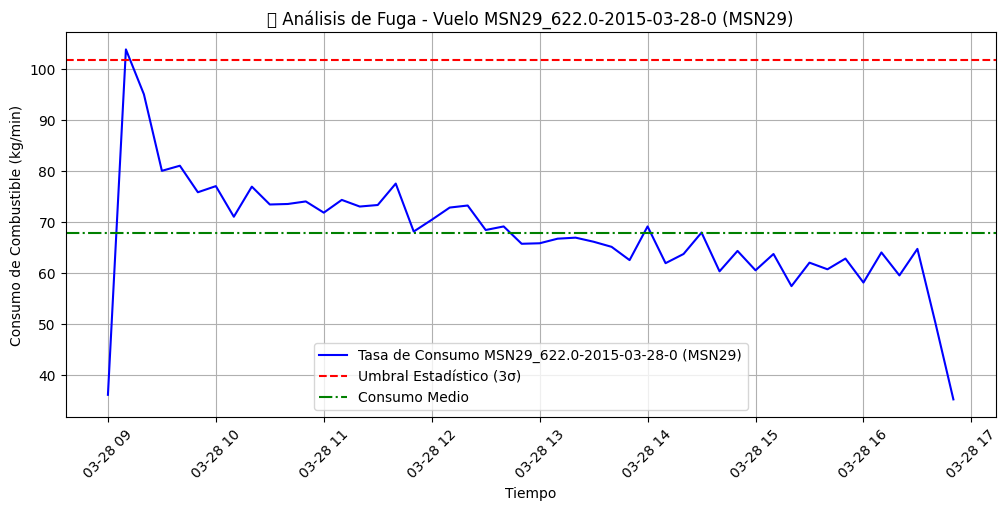

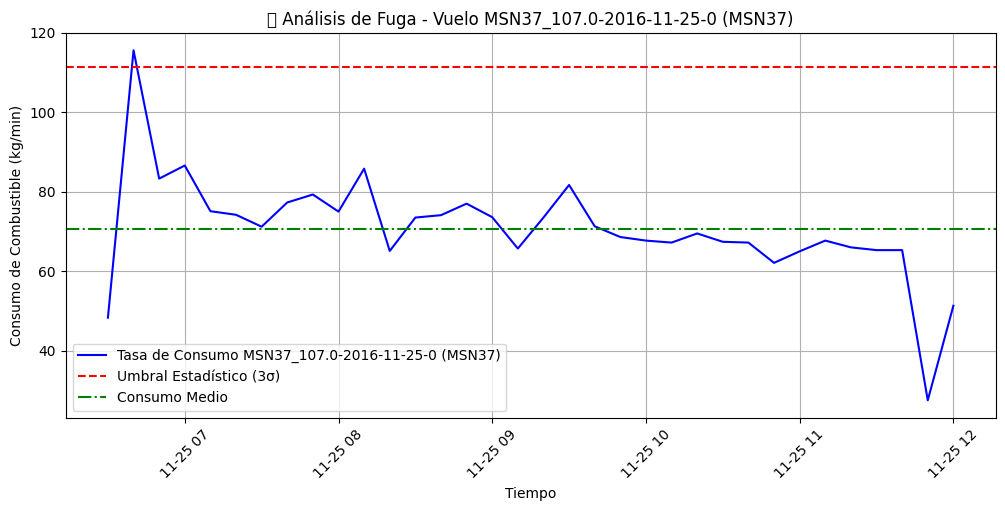

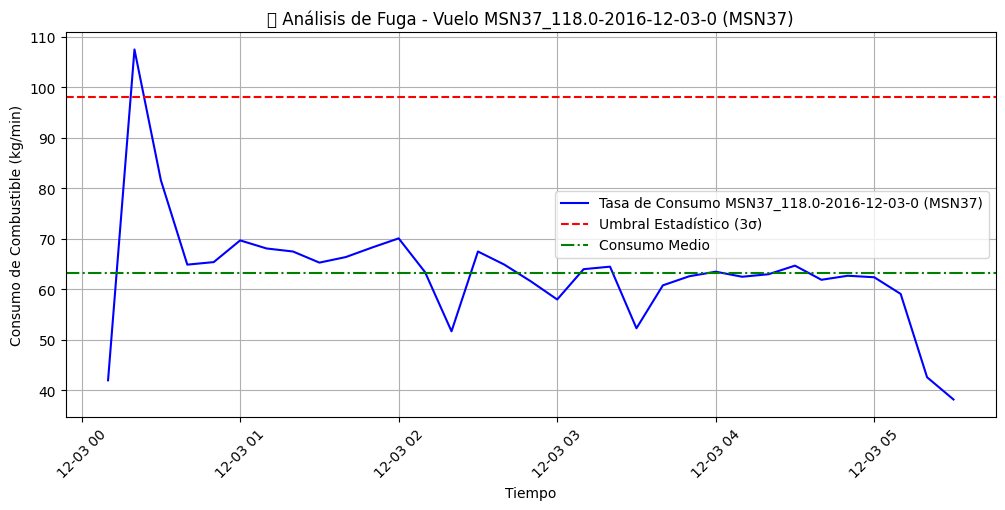

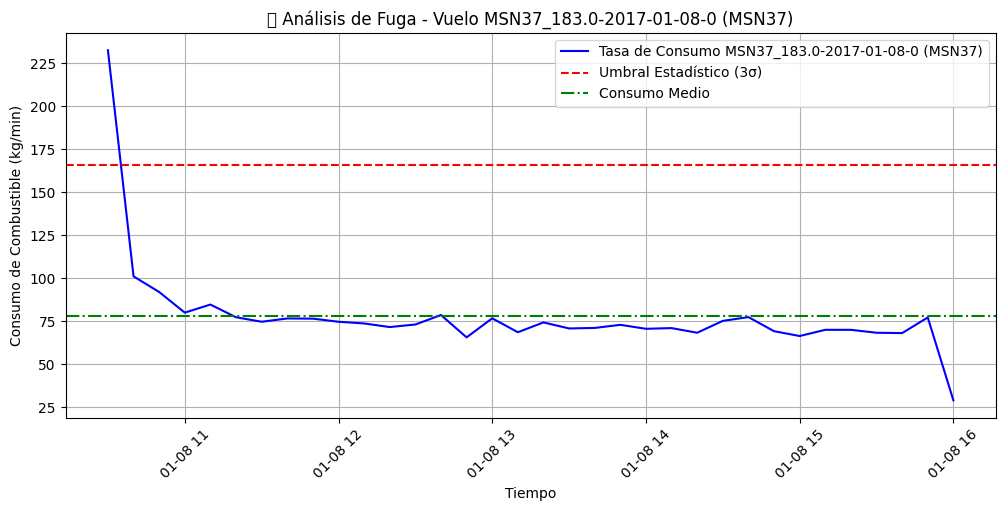

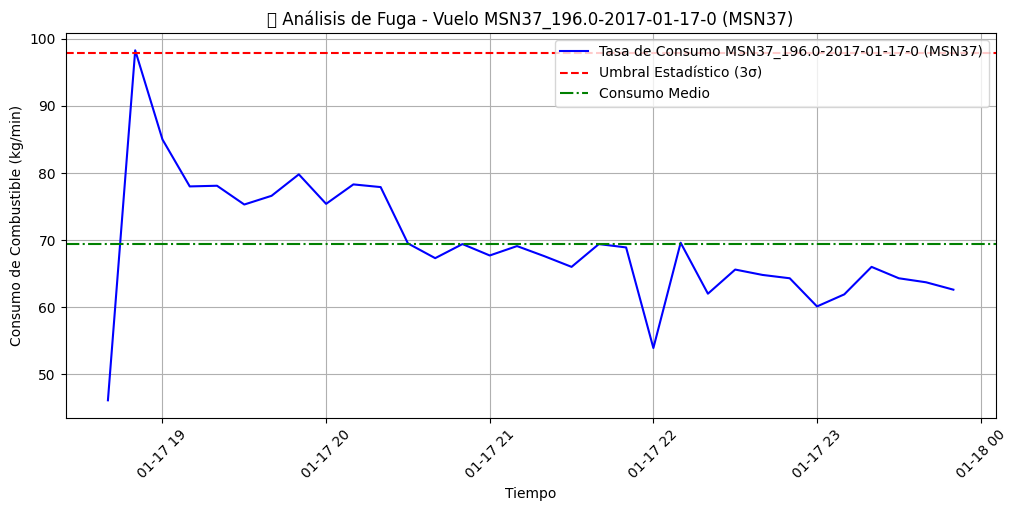

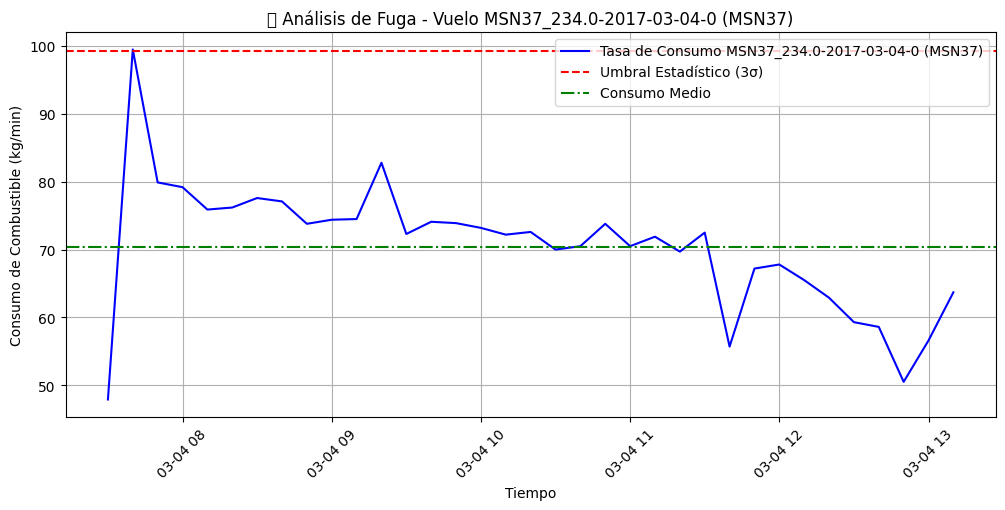

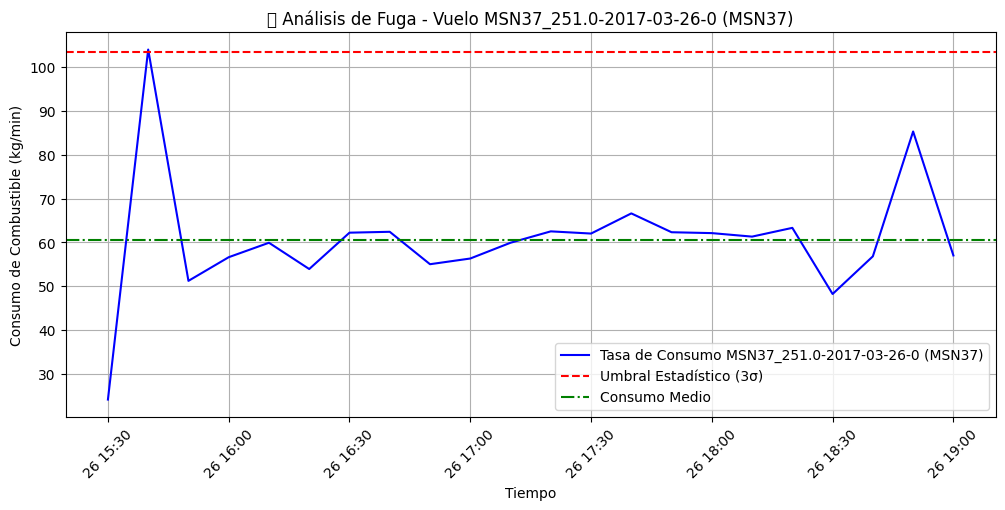

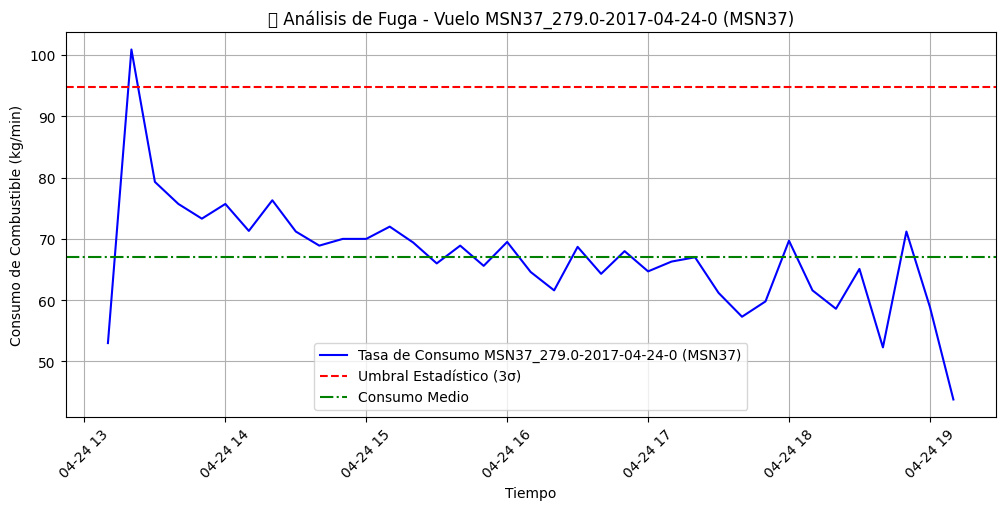

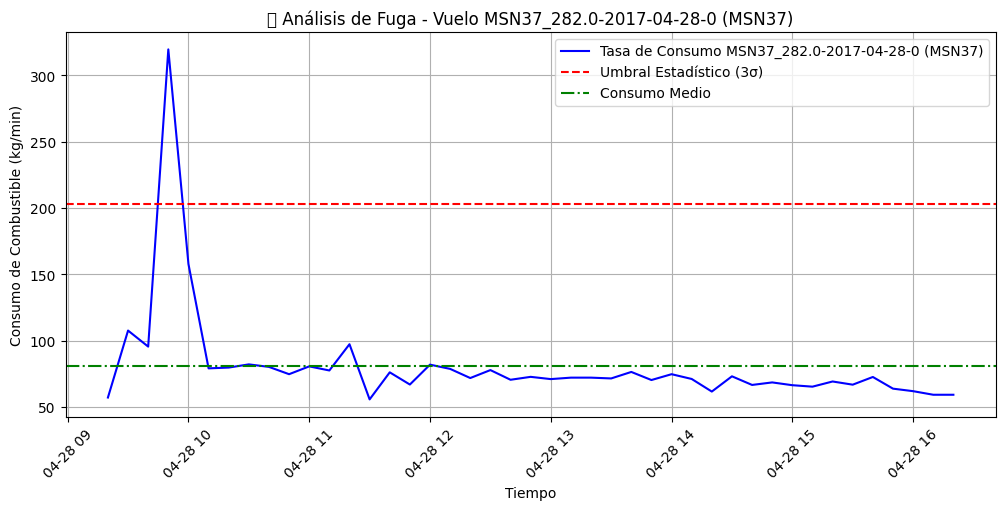

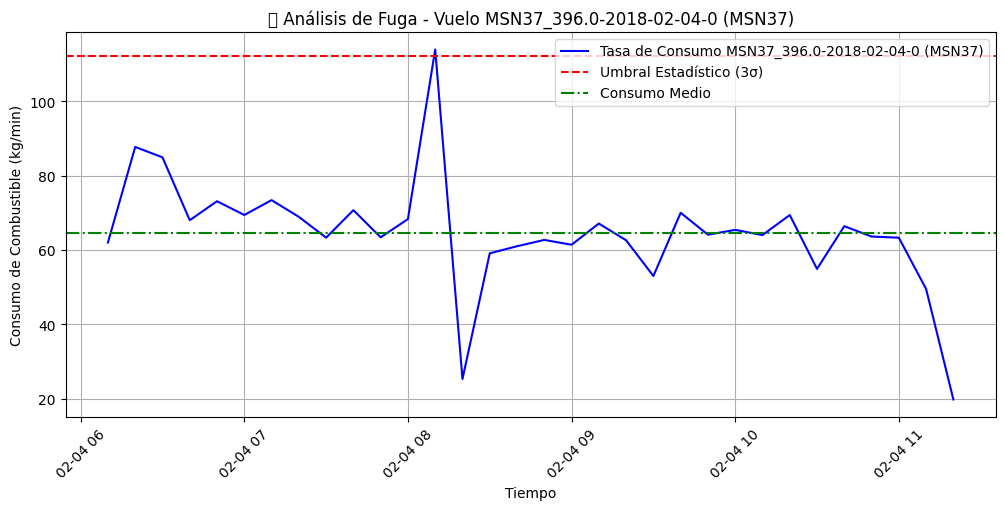

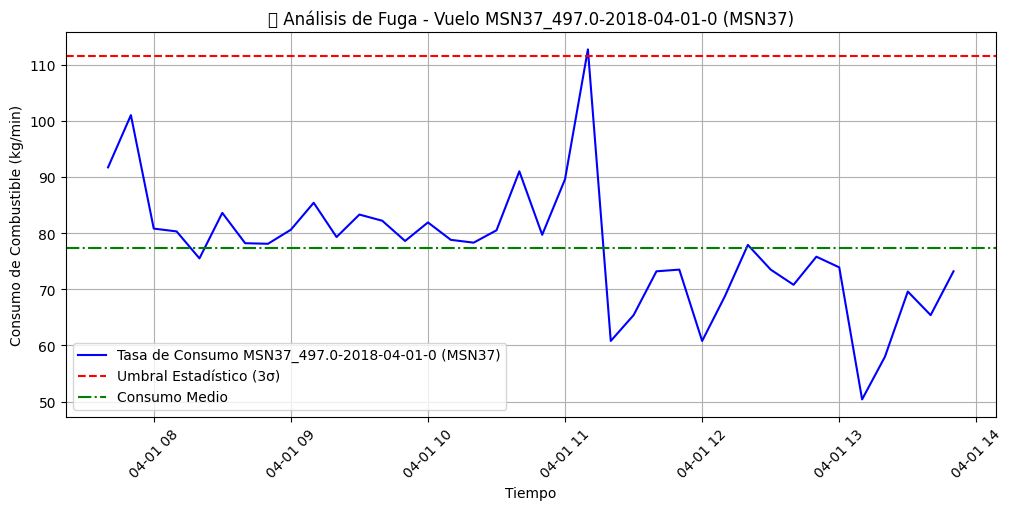

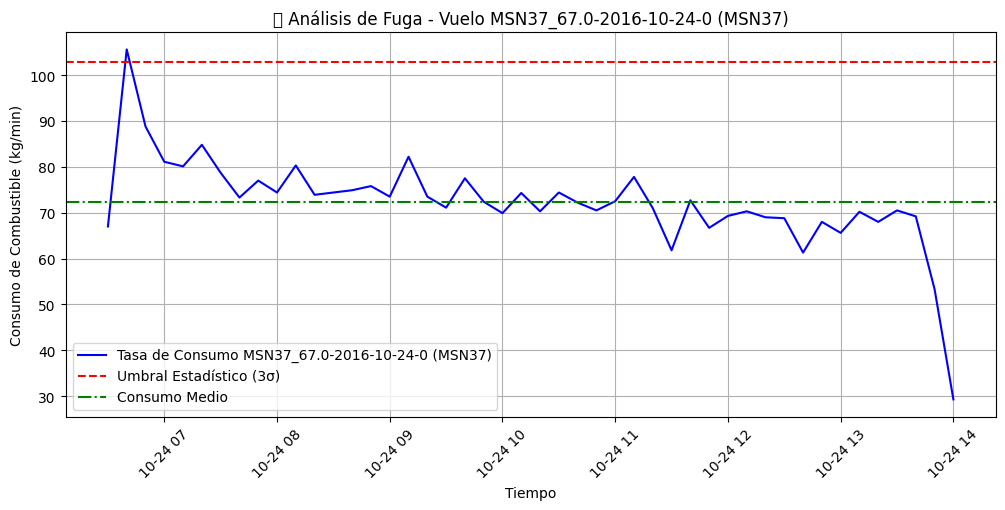

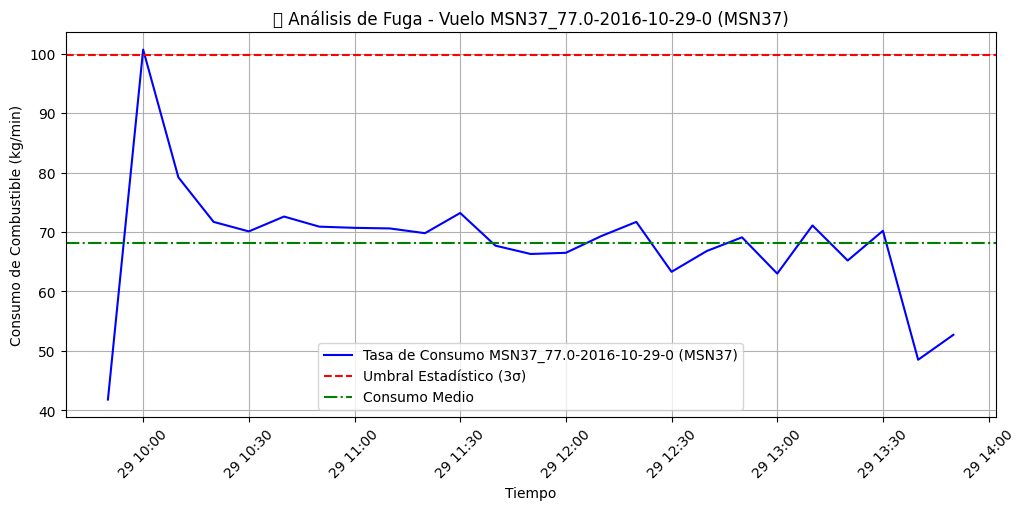

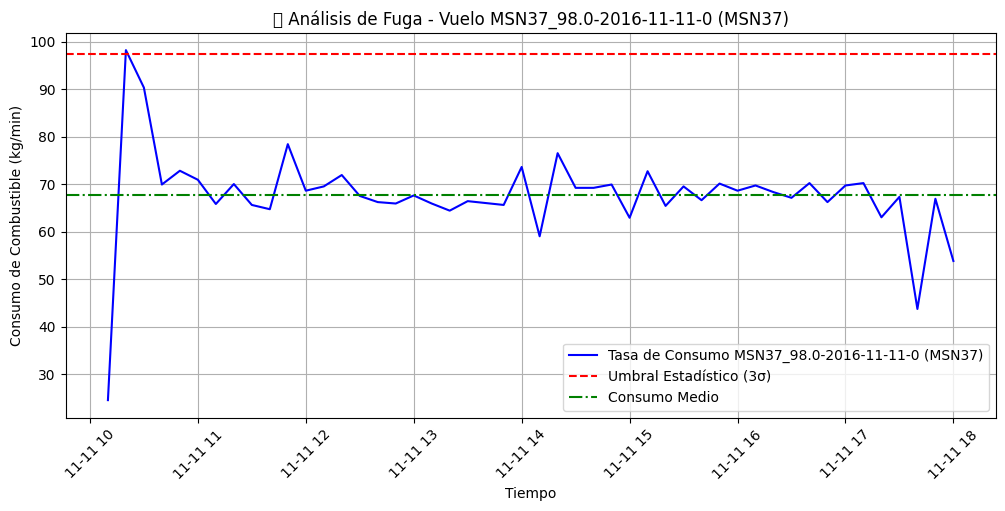

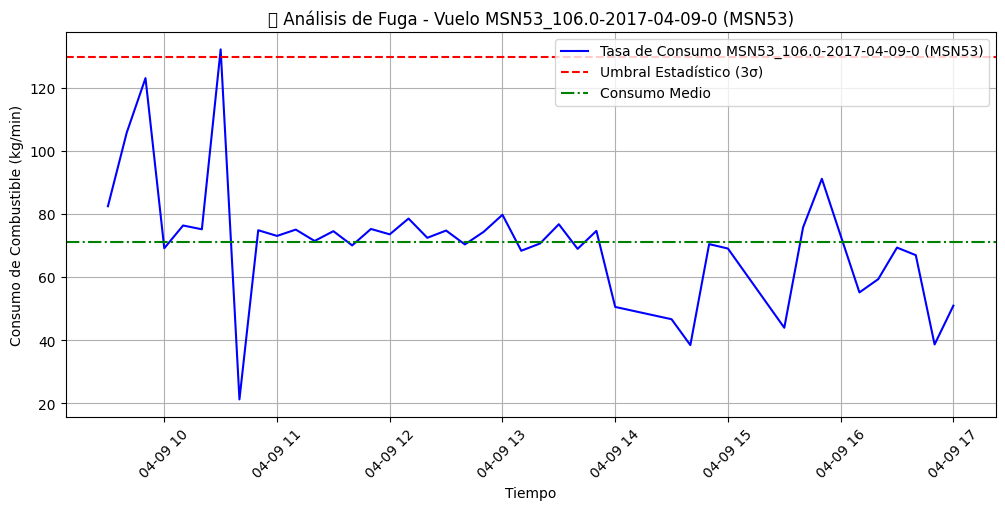

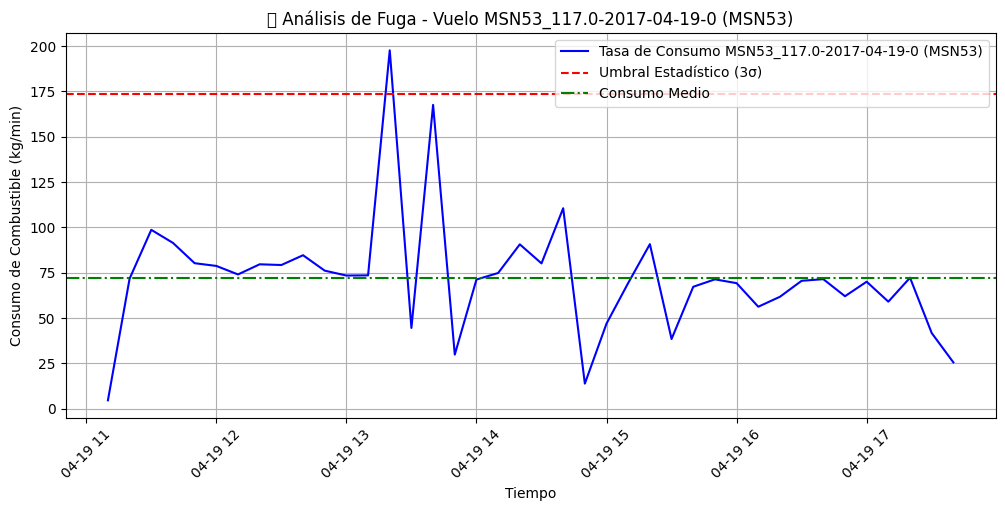

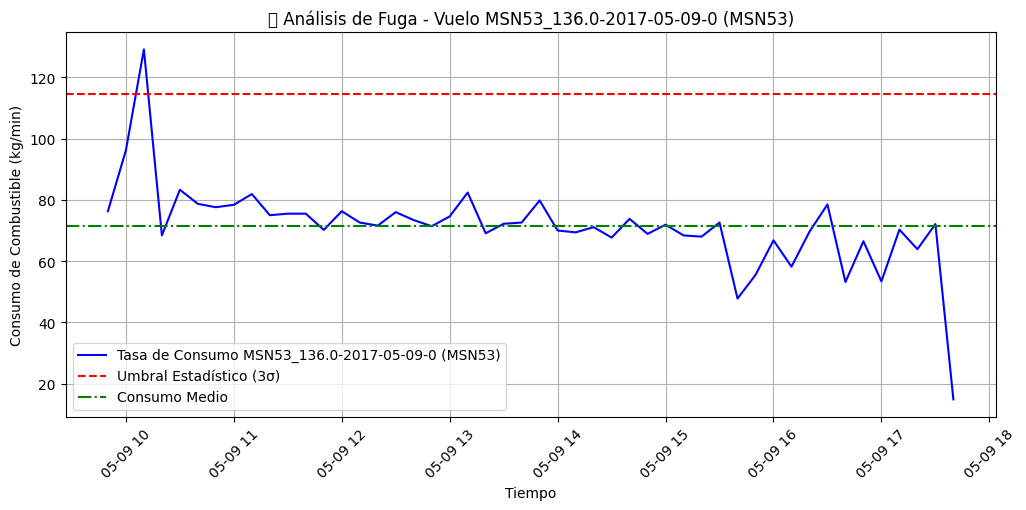

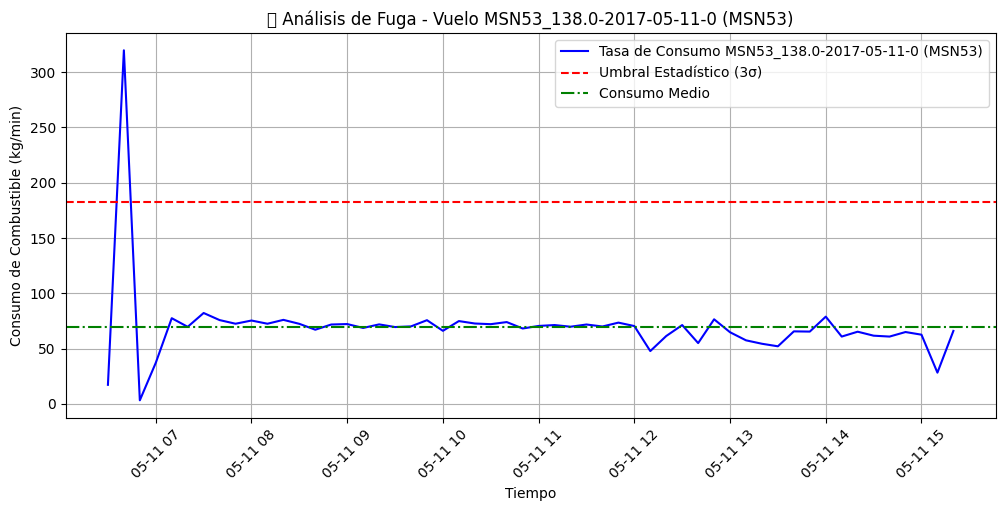

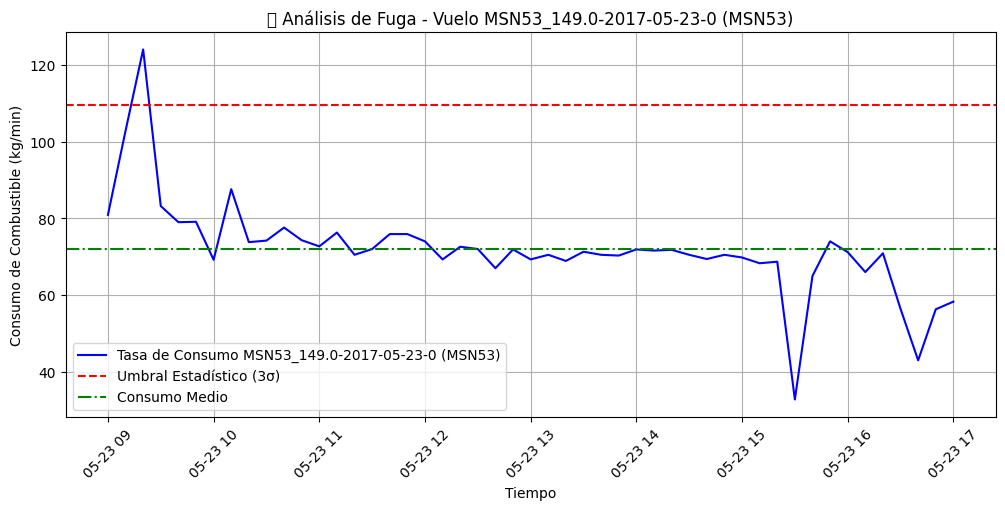

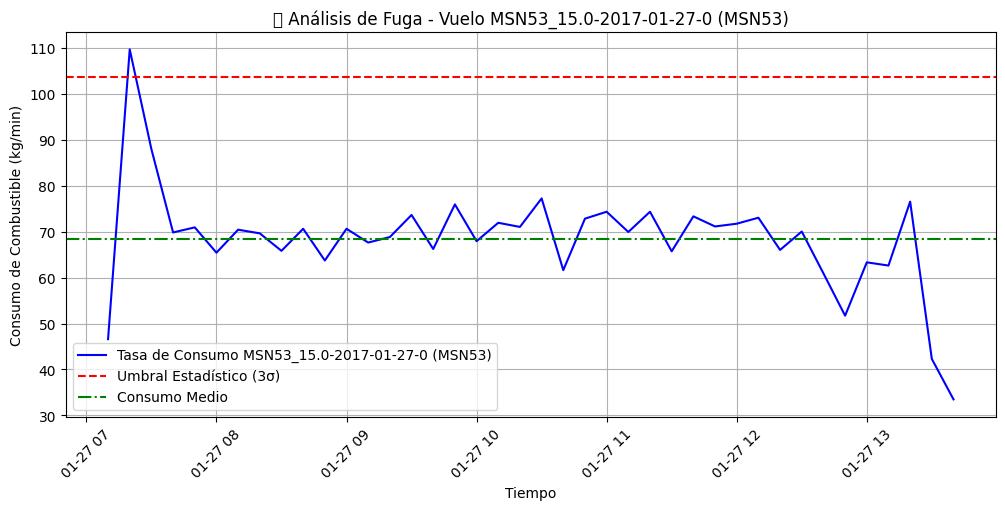

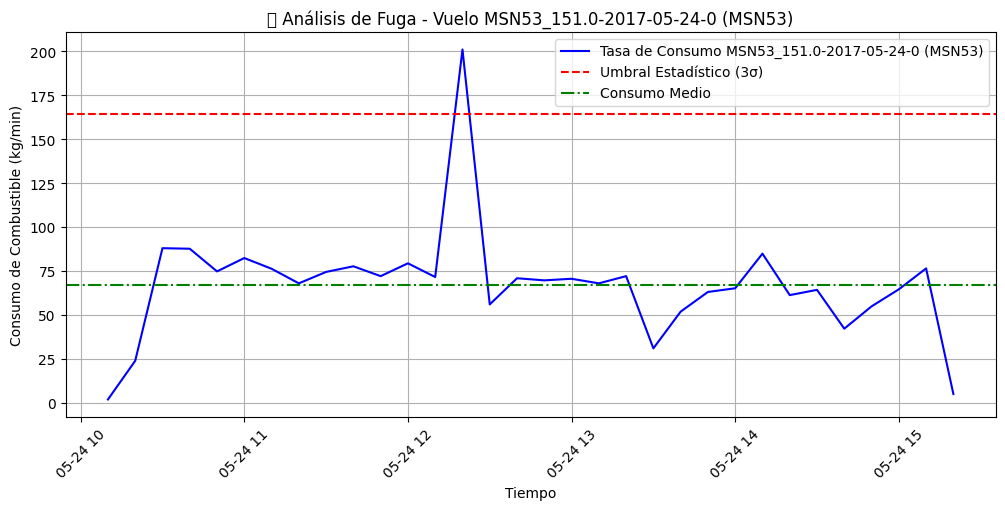

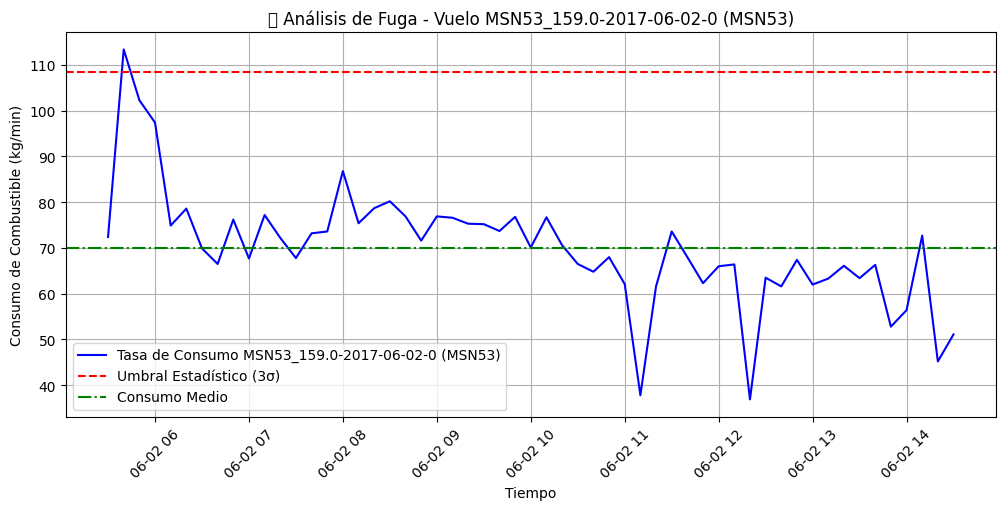

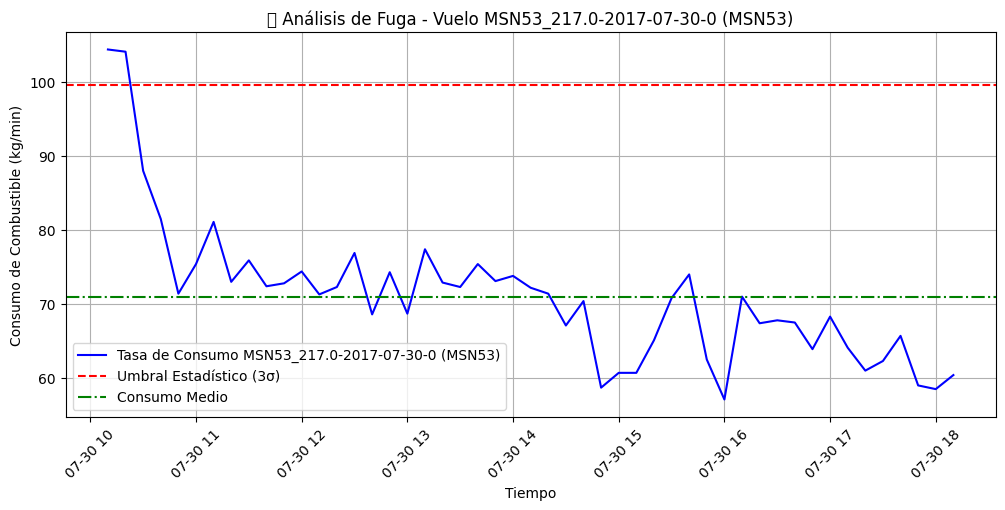

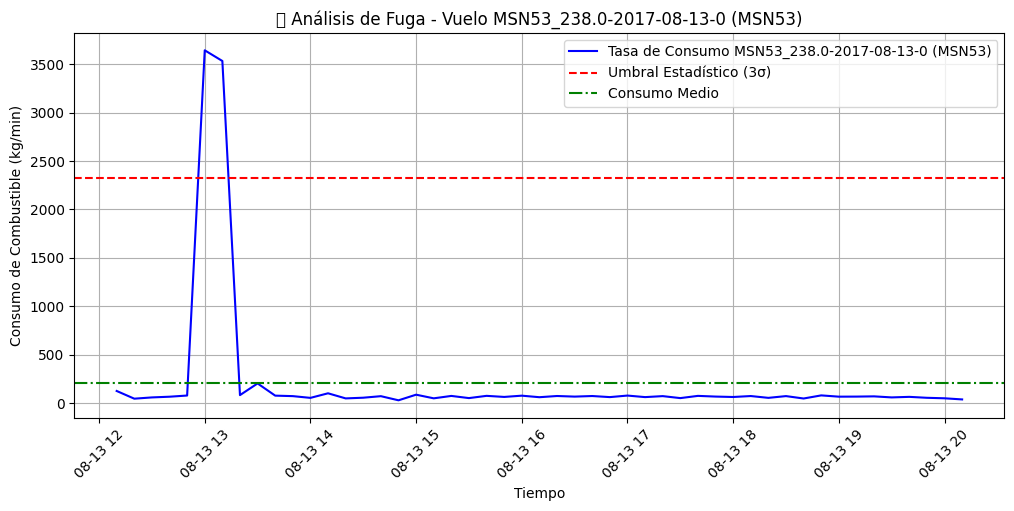

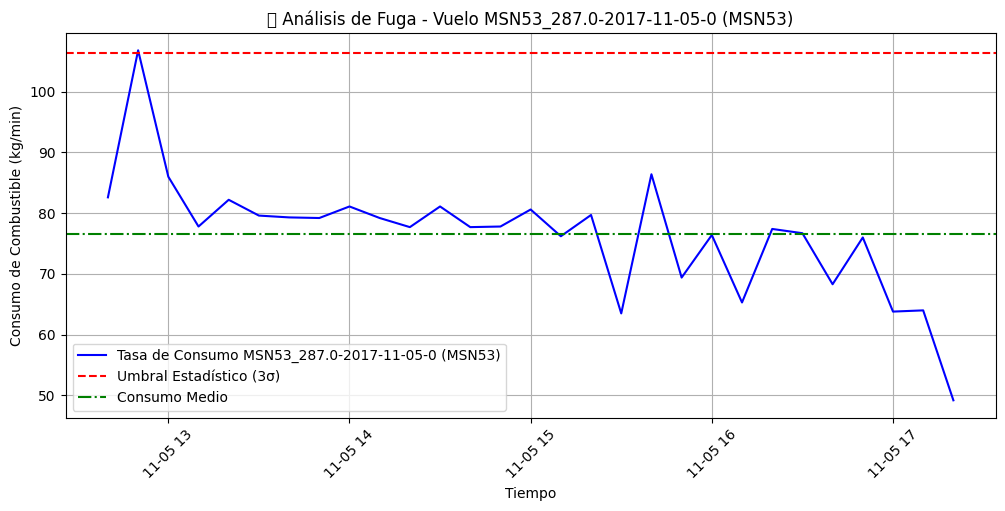

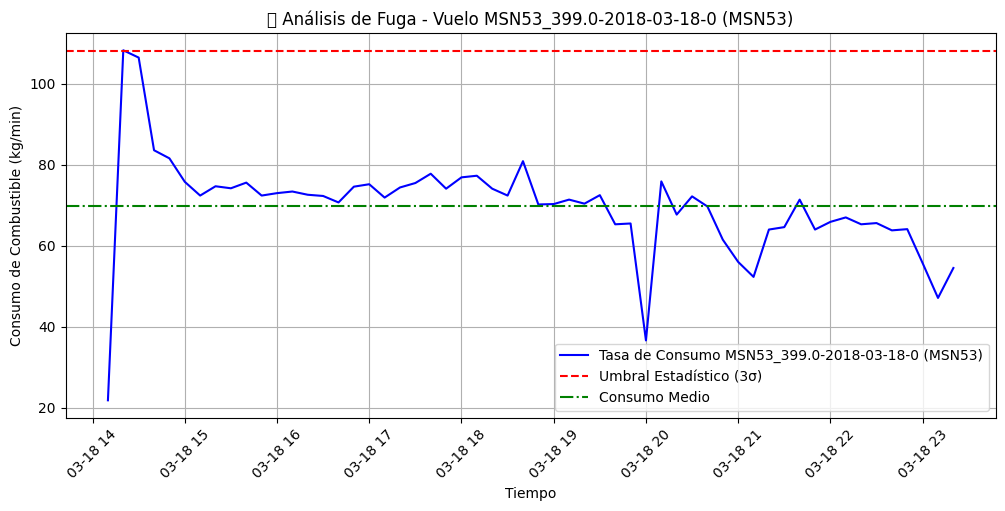

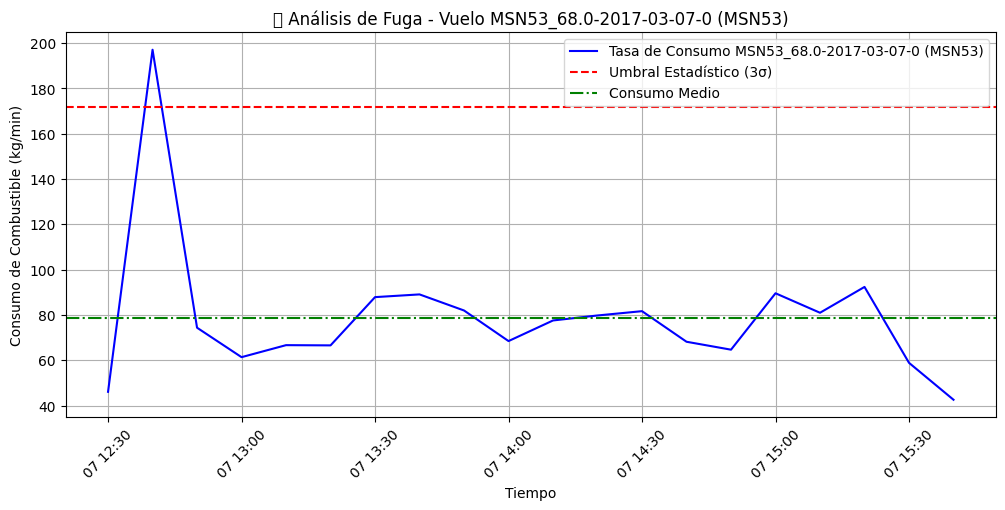

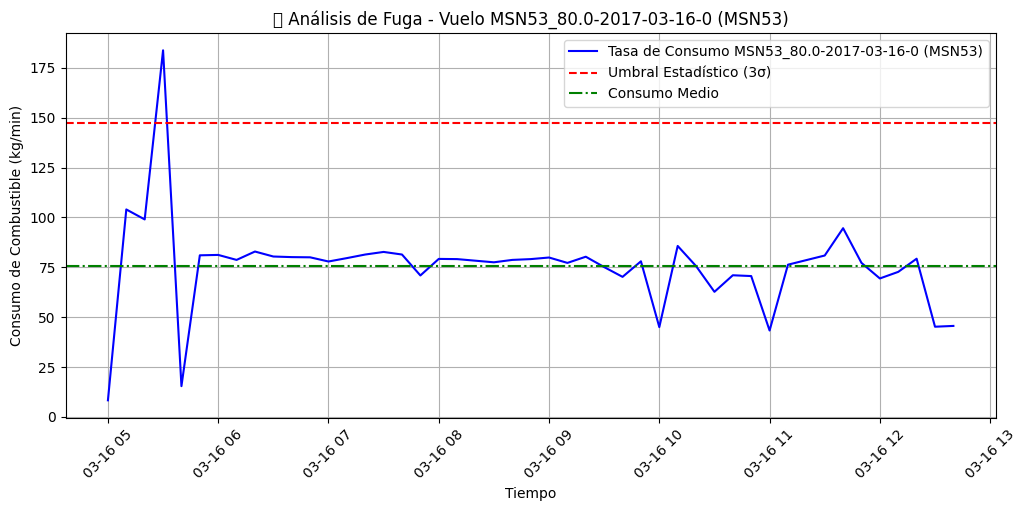

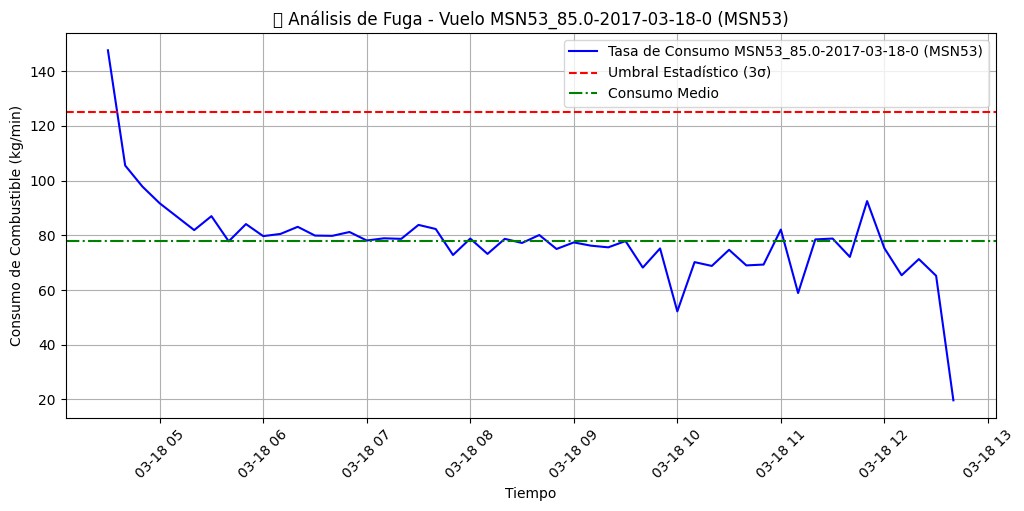

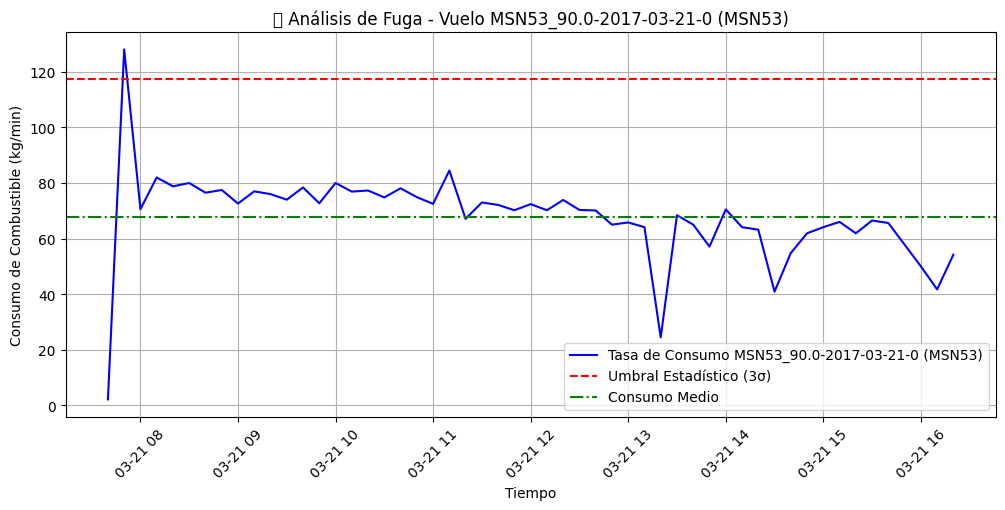

In [ ]:
import matplotlib.pyplot as plt

# Graficar solo vuelos con posibles fugas
leak_flights = df_resampled[df_resampled["Possible_Leak"]]["Unique_Flight"].unique()

for flight_id in leak_flights:
    flight_data = df_resampled[df_resampled["Unique_Flight"] == flight_id]
    
    if flight_data.empty:
        print(f"⚠️ No hay datos para el vuelo {flight_id}, omitiendo...")
        continue
    
    # Obtener el MSN asociado al vuelo (si existe)
    msn = flight_data["MSN"].iloc[0] if "MSN" in flight_data.columns else "Desconocido"

    # Calcular la media de Fuel Rate para el vuelo
    mean_fuel_rate = flight_data["Fuel_Rate"].mean(skipna=True)

    # Obtener umbral estadístico de 3σ para el vuelo
    threshold_value = thresholds[flight_data.index].iloc[0] if flight_data.index.isin(thresholds.index).any() else None

    # Crear la figura
    plt.figure(figsize=(12, 5))
    plt.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["Fuel_Rate"], label=f"Tasa de Consumo {flight_id} ({msn})", color="blue")

    # Agregar el umbral estadístico si está disponible
    if threshold_value is not None:
        plt.axhline(threshold_value, color="red", linestyle="--", label="Umbral Estadístico (3σ)")

    # Agregar la línea de consumo medio
    plt.axhline(mean_fuel_rate, color="green", linestyle="-.", label="Consumo Medio")

    # Etiquetas y formato del gráfico
    plt.xlabel("Tiempo")
    plt.ylabel("Consumo de Combustible (kg/min)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(f"🔍 Análisis de Fuga - Vuelo {flight_id} ({msn})")
    plt.grid(True)
    plt.show()


In [7]:
num_vuelos_con_fuga = df_resampled["Possible_Leak"].sum()
print(f"🔍 Número de vuelos con posibles fugas: {num_vuelos_con_fuga}")


🔍 Número de vuelos con posibles fugas: 95


In [8]:
porcentaje_fugas = (df_resampled["Possible_Leak"].mean()) * 100
print(f"📊 Porcentaje de datos marcados como fuga: {porcentaje_fugas:.2f}%")


📊 Porcentaje de datos marcados como fuga: 0.36%


In [ ]:
# Contar cuántas veces se detectó fuga por vuelo
fugas_por_vuelo = df_resampled[df_resampled["Possible_Leak"]]["Unique_Flight"].value_counts()

# Contar cuántas fugas hubo por cada MSN
fugas_por_msn = df_resampled[df_resampled["Possible_Leak"]].groupby("MSN")["Unique_Flight"].count()

# Mostrar los 10 vuelos con más detecciones de fuga
print("📌 Vuelos con más detecciones de fuga:")
print(fugas_por_vuelo.head(10))

# Mostrar cuántas fugas tiene cada avión (MSN)
print("\n📌 Fugas por MSN:")
print(fugas_por_msn.sort_values(ascending=False).head(10))


📌 Vuelos con más detecciones de fuga:
Unique_Flight
MSN53_238.0-2017-08-13-0     2
MSN53_217.0-2017-07-30-0     2
MSN10_248.0-2014-09-21-0     1
MSN29_2116.0-2016-12-16-0    1
MSN37_196.0-2017-01-17-0     1
MSN37_183.0-2017-01-08-0     1
MSN37_118.0-2016-12-03-0     1
MSN37_107.0-2016-11-25-0     1
MSN29_622.0-2015-03-28-0     1
MSN29_254.0-2014-09-22-0     1
Name: count, dtype: int64

📌 Fugas por MSN:
MSN
MSN11    25
MSN29    20
MSN53    18
MSN12    17
MSN37    13
MSN10     2
Name: Unique_Flight, dtype: int64


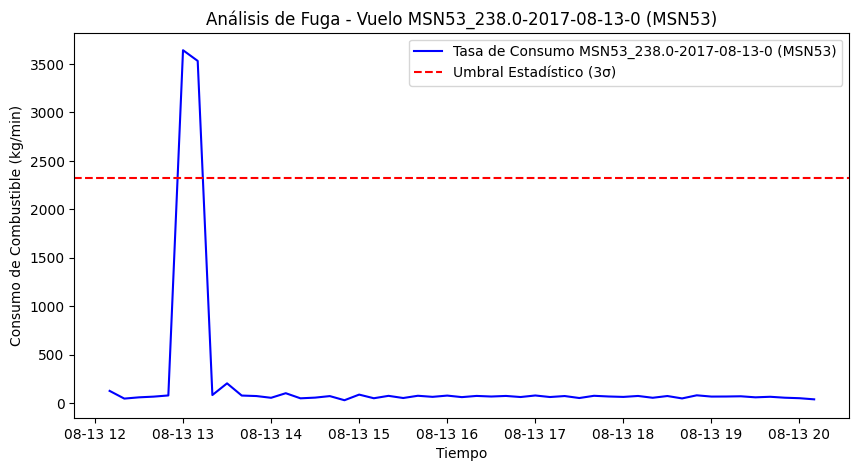

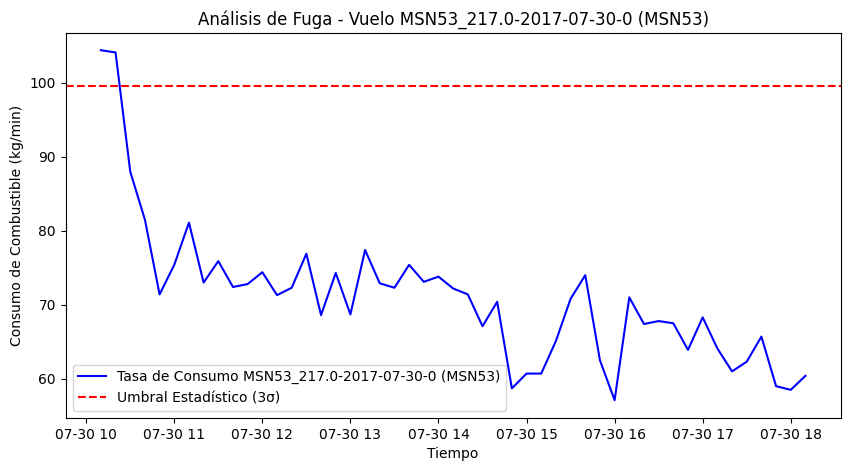

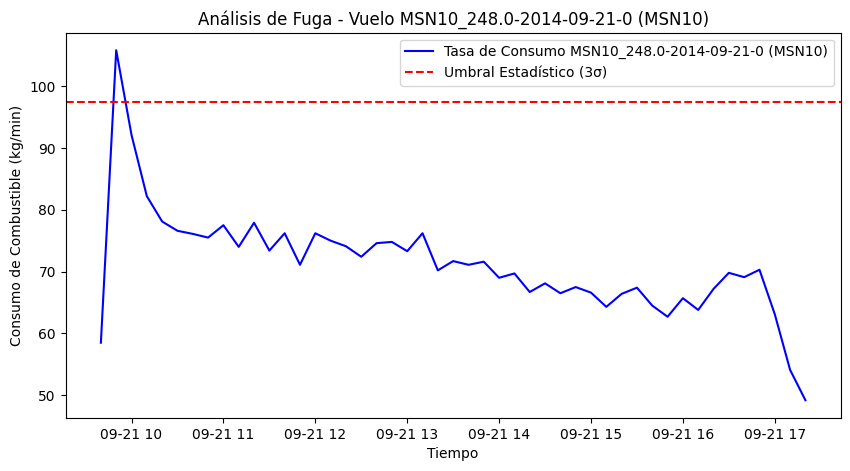

In [ ]:
# Seleccionar los 3 vuelos con más detecciones de fuga
top_vuelos = fugas_por_vuelo.head(3).index  

for flight_id in top_vuelos:
    flight_data = df_resampled[df_resampled["Unique_Flight"] == flight_id]
    
    if flight_data.empty:
        print(f"⚠️ No hay datos para el vuelo {flight_id}, omitiendo...")
        continue
    
    # Obtener el MSN asociado al vuelo
    msn = flight_data["MSN"].iloc[0]

    plt.figure(figsize=(10, 5))
    plt.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["Fuel_Rate"], label=f"Tasa de Consumo {flight_id} ({msn})", color="blue")

    # Verificar si hay datos suficientes para calcular el umbral estadístico
    if flight_data.index.isin(thresholds.index).any():
        plt.axhline(thresholds[flight_data.index].iloc[0], color="red", linestyle="--", label="Umbral Estadístico (3σ)")

    plt.xlabel("Tiempo")
    plt.ylabel("Consumo de Combustible (kg/min)")
    plt.legend()
    plt.title(f"Análisis de Fuga - Vuelo {flight_id} ({msn})")
    plt.show()


In [11]:
df_resampled[df_resampled["Unique_Flight"].isin(top_vuelos)][["Unique_Flight", "UTC_TIME_ROUNDED", "Fuel_Rate", "Fuel_Discrepancy"]].sort_values(by="Fuel_Discrepancy", ascending=False).head(10)


Unique_Flight    UTC_TIME_ROUNDED  Fuel_Rate  \
23556  MSN53_238.0-2017-08-13-0 2017-08-13 13:10:00     3532.6   
23581  MSN53_238.0-2017-08-13-0 2017-08-13 17:20:00       72.5   
23314  MSN53_217.0-2017-07-30-0 2017-07-30 10:40:00       81.5   
23585  MSN53_238.0-2017-08-13-0 2017-08-13 18:00:00       63.5   
355    MSN10_248.0-2014-09-21-0 2014-09-21 14:50:00       67.5   
23316  MSN53_217.0-2017-07-30-0 2017-07-30 11:00:00       75.4   
23555  MSN53_238.0-2017-08-13-0 2017-08-13 13:00:00     3642.9   
23318  MSN53_217.0-2017-07-30-0 2017-07-30 11:20:00       73.0   
334    MSN10_248.0-2014-09-21-0 2014-09-21 11:20:00       77.9   
346    MSN10_248.0-2014-09-21-0 2014-09-21 13:20:00       70.2   

       Fuel_Discrepancy  
23556               0.0  
23581               0.0  
23314               0.0  
23585               0.0  
355                 0.0  
23316               0.0  
23555               0.0  
23318               0.0  
334                 0.0  
346                 0.0

In [12]:
promedio_fuel_rate = df_resampled["Fuel_Rate"].mean()
print(f"📊 Consumo promedio de combustible: {promedio_fuel_rate:.2f} kg/min")


📊 Consumo promedio de combustible: 68.59 kg/min


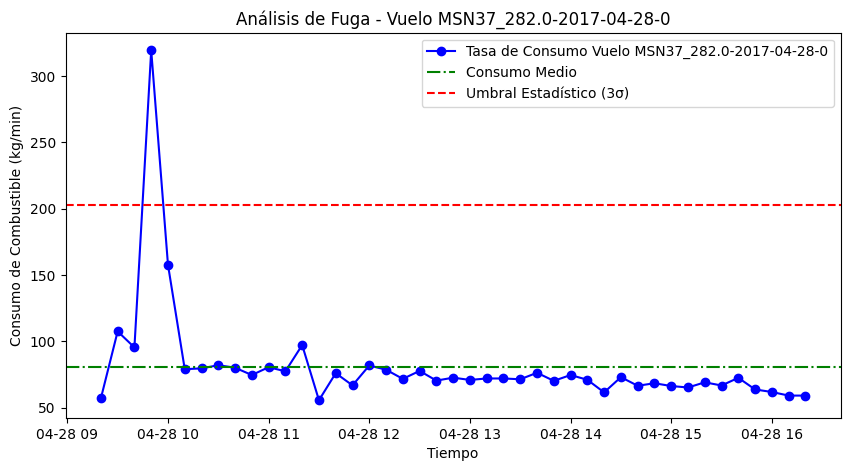

In [15]:
flight_id = "MSN37_282.0-2017-04-28-0"
flight_data = df_resampled[df_resampled["Unique_Flight"] == flight_id]

plt.figure(figsize=(10, 5))
plt.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["Fuel_Rate"], label=f"Tasa de Consumo Vuelo {flight_id}", color="blue", marker="o")
plt.axhline(flight_data["Fuel_Rate"].mean(), color="green", linestyle="-.", label="Consumo Medio")
plt.axhline(thresholds[flight_data.index].iloc[0], color="red", linestyle="--", label="Umbral Estadístico (3σ)")
plt.xlabel("Tiempo")
plt.ylabel("Consumo de Combustible (kg/min)")
plt.legend()
plt.title(f"Análisis de Fuga - Vuelo {flight_id}")
plt.show()


In [19]:
df_resampled[["Unique_Flight", "Fuel_Rate"]].sort_values(by="Fuel_Rate", ascending=False).head(20)


Unique_Flight    Fuel_Rate
23555   MSN53_238.0-2017-08-13-0  3642.900000
23556   MSN53_238.0-2017-08-13-0  3532.600000
11702  MSN29_1094.0-2015-09-30-0   924.200000
7013    MSN12_112.0-2015-04-29-0   848.300000
9205    MSN12_363.0-2017-10-16-0   831.500000
24318   MSN53_302.0-2017-11-18-0   734.100000
22424   MSN53_138.0-2017-05-11-0   319.600000
19396   MSN37_282.0-2017-04-28-0   319.500000
24314   MSN53_302.0-2017-11-18-0   282.000000
13507  MSN29_1735.0-2016-08-01-0   269.500000
18433   MSN37_183.0-2017-01-08-0   232.600000
21784    MSN37_97.0-2016-11-11-0   224.485938
8528    MSN12_230.0-2016-02-09-0   223.000000
23558   MSN53_238.0-2017-08-13-0   203.500000
22650   MSN53_151.0-2017-05-24-0   201.100000
22136   MSN53_117.0-2017-04-19-0   197.700000
25728    MSN53_68.0-2017-03-07-0   197.100000
6330     MSN11_54.0-2014-10-27-0   195.190308
24315   MSN53_302.0-2017-11-18-0   188.800000
21785    MSN37_97.0-2016-11-11-0   188.685937

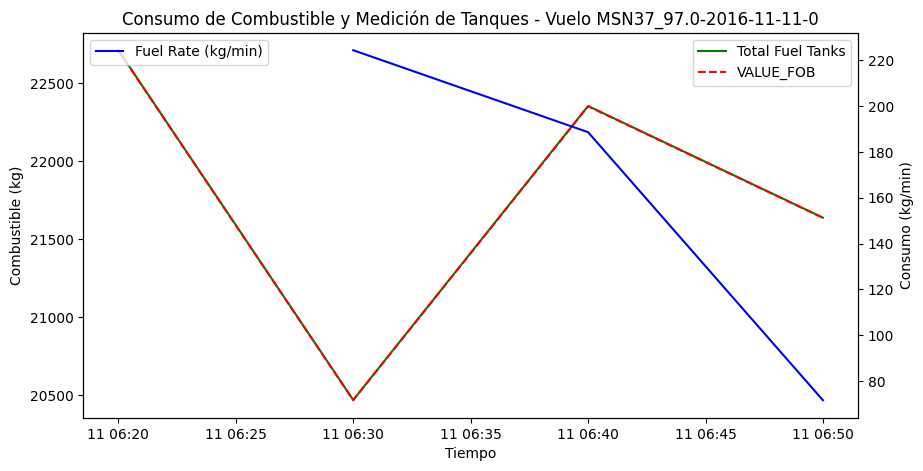

In [22]:
import matplotlib.pyplot as plt

# Filtrar los datos del vuelo específico
flight_id = "MSN37_97.0-2016-11-11-0"
flight_data = df_resampled[df_resampled["Unique_Flight"] == flight_id]

# Crear la figura
fig, ax1 = plt.subplots(figsize=(10, 5))

# Eje 1 (Combustible en tanques y FOB)
ax1.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["Total_Fuel_Tanks"], color="green", label="Total Fuel Tanks")
ax1.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["VALUE_FOB"], color="red", linestyle="--", label="VALUE_FOB")
ax1.set_ylabel("Combustible (kg)")
ax1.set_xlabel("Tiempo")
ax1.legend(loc="upper right")

# Eje 2 (Consumo de combustible)
ax2 = ax1.twinx()
ax2.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["Fuel_Rate"], color="blue", label="Fuel Rate (kg/min)")
ax2.set_ylabel("Consumo (kg/min)")
ax2.legend(loc="upper left")

# Título
plt.title(f"Consumo de Combustible y Medición de Tanques - Vuelo {flight_id}")
plt.show()


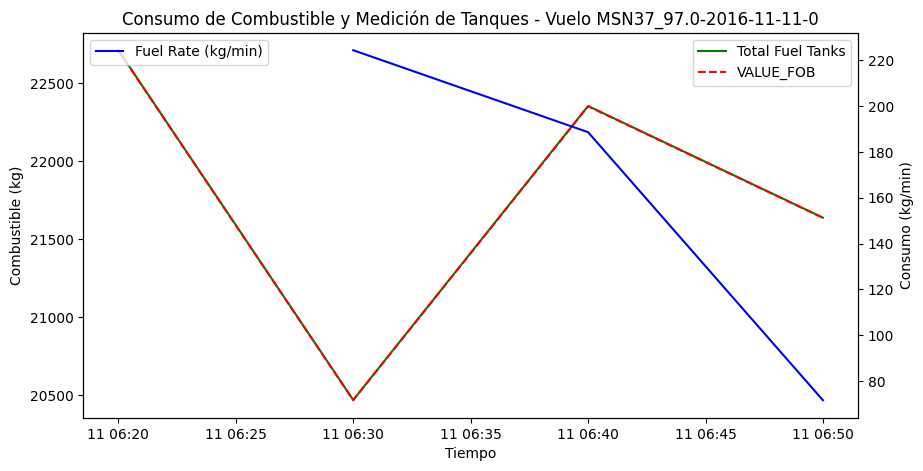

C:\Users\santi\AppData\Local\Temp\ipykernel_29680\2829229476.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data["Wing_Fuel_Diff"] = flight_data["VALUE_FUEL_QTY_LXT"] - flight_data["VALUE_FUEL_QTY_RXT"]


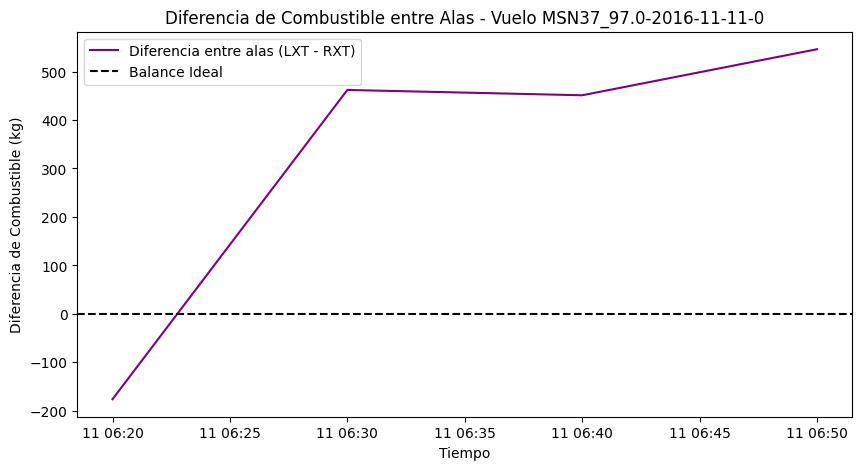

In [ ]:
import matplotlib.pyplot as plt

# Lista de vuelos específicos
selected_flights = [
   "MSN37_97.0-2016-11-11-0"
]

for flight_id in selected_flights:
    flight_data = df_resampled[df_resampled["Unique_Flight"] == flight_id]

    # **Gráfica 1: Total Fuel Tanks y VALUE_FOB + Fuel Rate**
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Eje 1 (Combustible en tanques y FOB)
    ax1.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["Total_Fuel_Tanks"], color="green", label="Total Fuel Tanks")
    ax1.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["VALUE_FOB"], color="red", linestyle="--", label="VALUE_FOB")
    ax1.set_ylabel("Combustible (kg)")
    ax1.set_xlabel("Tiempo")
    ax1.legend(loc="upper right")

    # Eje 2 (Consumo de combustible)
    ax2 = ax1.twinx()
    ax2.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["Fuel_Rate"], color="blue", label="Fuel Rate (kg/min)")
    ax2.set_ylabel("Consumo (kg/min)")
    ax2.legend(loc="upper left")

    plt.title(f"Consumo de Combustible y Medición de Tanques - Vuelo {flight_id}")
    plt.show()

    # **Gráfica 2: Diferencia entre alas**
    plt.figure(figsize=(10, 5))
    flight_data["Wing_Fuel_Diff"] = flight_data["VALUE_FUEL_QTY_LXT"] - flight_data["VALUE_FUEL_QTY_RXT"]
    
    plt.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["Wing_Fuel_Diff"], color="purple", label="Diferencia entre alas (LXT - RXT)")
    plt.axhline(0, color="black", linestyle="--", label="Balance Ideal")
    
    plt.xlabel("Tiempo")
    plt.ylabel("Diferencia de Combustible (kg)")
    plt.legend()
    plt.title(f"Diferencia de Combustible entre Alas - Vuelo {flight_id}")
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Calcular la diferencia entre VALUE_FOB y Total Fuel Tanks
df_resampled["FOB_vs_Tanks_Diff"] = df_resampled["VALUE_FOB"] - df_resampled["Total_Fuel_Tanks"]

# Graficar para vuelos con fugas sospechosas
leak_flights = df_resampled[df_resampled["Possible_Leak"]]["Unique_Flight"].unique()

for flight_id in leak_flights:
    flight_data = df_resampled[df_resampled["Unique_Flight"] == flight_id]

    plt.figure(figsize=(10, 5))
    plt.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["FOB_vs_Tanks_Diff"], label="Diferencia FOB vs. Tanques", color="purple")
    plt.axhline(0, color="black", linestyle="--", label="Sin discrepancia")
    plt.xlabel("Tiempo")
    plt.ylabel("Diferencia de Combustible (kg)")
    plt.legend()
    plt.title(f"Discrepancia VALUE_FOB vs. Sensores - Vuelo {flight_id}")
    plt.show()


In [ ]:
# Calcular combustible en cada lado del avión
df_resampled["Fuel_Left"] = df_resampled["VALUE_FUEL_QTY_LXT"] + df_resampled["VALUE_FUEL_QTY_FT1"] + df_resampled["VALUE_FUEL_QTY_FT3"]
df_resampled["Fuel_Right"] = df_resampled["VALUE_FUEL_QTY_RXT"] + df_resampled["VALUE_FUEL_QTY_FT2"] + df_resampled["VALUE_FUEL_QTY_FT4"]

# Graficar para vuelos con posibles fugas
for flight_id in leak_flights:
    flight_data = df_resampled[df_resampled["Unique_Flight"] == flight_id]

    plt.figure(figsize=(10, 5))
    plt.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["Fuel_Left"], label="Combustible Izquierdo", color="blue")
    plt.plot(flight_data["UTC_TIME_ROUNDED"], flight_data["Fuel_Right"], label="Combustible Derecho", color="red")
    plt.xlabel("Tiempo")
    plt.ylabel("Combustible (kg)")
    plt.legend()
    plt.title(f"Comparación Combustible Izq vs. Der - Vuelo {flight_id}")
    plt.show()


In [ ]:
num_vuelos_con_fuga = df_resampled[df_resampled["Possible_Leak"]]["Unique_Flight"].nunique()
total_vuelos = df_resampled["Unique_Flight"].nunique()
print(f"🔍 Número de vuelos con posibles fugas: {num_vuelos_con_fuga} de {total_vuelos} vuelos.")
